  # Charity Analysis on Form 990
  ## Motivation
  
  Analyze non-profit organization to predict number of volunteer
  

In [314]:
import pandas as pd 
import sqlalchemy as sa
from pathlib import Path
from sqlalchemy import create_engine
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt
import seaborn as sns
from pylab import rcParams
from collections import Counter
%matplotlib inline

In [315]:
#%%
query=''' SELECT *
FROM Open990
'''
e = sa.create_engine(r'sqlite:///D:\Program_practices\Charity\open990database.db')
df= pd.read_sql_query(query, e)
irrelevant=['country', 'org_form.other_form_desc', 'grp_exempt_num', 'state_legaldomicile', 
           'grp_return', 'grp_subs_all_incl', 'exempt_status.501c3', 'exempt_status.501c_any',
           'exempt_status.501c_txt','income_tot_unrelated', 'income_net_unrelated', 
           'rev_giftsgrants_tot_prioryr', 'rev_prgmservice_prioryr', 'rev_investmt_prioryr',
           'rev_other_prioryr','fundraiseservfee_expense_tot_prioryr', 'grants_expense_tot_prioryr',
           'benefits_expense_tot_prioryr', 'salaries_expense_tot_prioryr', 'fundraise_expense_tot_curyr',
           'other_expense_tot_prioryr','rev_giftsgrants_tot_curyr', 'rev_prgmservice_curyr',
           'rev_investmt_curyr', 'rev_other_curyr', 'fundraiseservfee_expense_tot_curyr', 'grants_expense_tot_curyr',
           'benefits_expense_tot_curyr', 'salaries_expense_tot_curyr', 'fundraise_expense_tot_curyr',
           'other_expense_tot_curyr','operate_hospfacility', 'relationsamongemployees', 'delegate_management',
           'memb_or_stockholder', 'memb_elect_board','decisions_outside_board', 'govern_body_minutes',
           'committee_minutes', 'no_officer_address', 'policies_ref_chapt', '990_to_members', 'conflict_interest_policy',
           'conflict_disclosure','enforce_conflict_policy', 'whistleblower_policy', 'doc_retention_policy',
           'ceo_comp_review','officer_comp_review', 'in_joint_venture', 'joint_venture_policy', 
           'forms_ownwebsite', 'record_id', 'schema_version', 'irs_efile_id', 'random_string', 'tax_date_begin', 
            'tax_date_end', 'doing_business_as', 'phone', 'website', 'address', 'zip'
           ]
df=df.drop(columns=irrelevant)
w= sa.create_engine(r'sqlite:///D:\Program_practices\Charity\open990database.sqlite')
df.to_sql('Full_data', w, if_exists='replace', index=False)

In [316]:
#Deleting rows with no volunteers after filling them in
df['volunteer_tot_ct']=df['volunteer_tot_ct'].fillna(0).astype(int)
df=df[df['volunteer_tot_ct'] !=0]

key=df[['ein', 'ntee_code_nccs', 'ntee_description_nccs']]
key=key.drop_duplicates().dropna().reset_index(drop=True)

# Only keeping the most recent tax year
df=df.groupby('ein', group_keys=False).apply(lambda x: x.loc[x['tax_yr'].idxmax()])
df.index.name=None
df=pd.merge(df,key, on='ein', how='left')

# The duplicates are due to changes in business ntee code; we will take the newest code
df = df.drop_duplicates(subset='ein', keep="last")

In [317]:
df.head()

,ein,name_org,tax_yr,city,state,org_form.association,org_form.corp,org_form.other_form,org_form.trust,formation_yr,...,accountreceivable_net_endyr,invest_publicsec_endyr,invest_othersec_endyr,invest_prog_endyr,asset_intangible_endyr,asset_unrestrictnet_endyr,asset_temprestrictnet_endyr,asset_permrestrictnet_endyr,ntee_code_nccs_y,ntee_description_nccs_y
0,10018922,AMERICAN LEGION AUXILIARY DEPARTMENT OF MAINE,2015,OAKLAND,ME,None,true,None,None,1920,...,None,None,None,None,None,71359,158886,None,W30,"Military, Veterans' Organizations"
1,10018927,AMERICAN LEGION POST 5 BOURQUE-LANIGAN,2015,WATERVILLE,ME,None,true,None,None,1926,...,None,None,None,None,None,None,None,None,W30,"Military, Veterans' Organizations"
2,10019705,Ancient Free and Accepted Masons of Maine Gran...,2017,Holden,ME,None,true,None,None,1820,...,None,1212819,None,None,None,1545025,61557,136978,Y42,Domestic Fraternal Societies
3,10022320,AUGUSTA COUNTRY CLUB,2013,MANCHESTER,ME,None,true,None,None,1916,...,91733,None,None,None,None,None,None,None,N50,"Recreational, Pleasure, or Social Club"
4,10022415,Kennebec Valley Chamber of Commerce,2016,Augusta,ME,None,true,None,None,1932,...,95,121829,None,None,None,196796,None,None,S41,Promotion of Business


In [318]:
# data cleaning
df['org_form.association'] = df['org_form.association'].apply(lambda true: True if true else False)
df['org_form.corp'] = df['org_form.corp'].apply(lambda true: True if true else False)
df['org_form.other_form'] = df['org_form.other_form'].apply(lambda true: True if true else False)
df['org_form.trust'] = df['org_form.trust'].apply(lambda true: True if true else False)

# fill in formation yr with tax_yr if null of if more than 2018
df['formation_yr']=df['formation_yr'].fillna(value=df['tax_yr']).astype(int)
df['formation_yr']=df[['formation_yr','tax_yr']].apply(lambda x: x['tax_yr'] if x['formation_yr']>2018 else x['formation_yr'], axis=1).astype(int)

In [319]:
df=df.drop(columns=['ntee_code_nccs_x', 'ntee_description_nccs_x'])

In [320]:
df['discontinue_dispose25']=df['discontinue_dispose25'].apply(lambda dd: 1 if dd=='true' else 0)
# df['volunteer_tot_ct']=df['volunteer_tot_ct'].fillna(0).astype(int)
df['material_diversion']=df['material_diversion'].apply(lambda md: 1 if md=='yes' else 0)
df['local_chapt']=df['local_chapt'].apply(lambda md: 1 if md=='yes' else 0)

In [321]:
df.head()

,ein,name_org,tax_yr,city,state,org_form.association,org_form.corp,org_form.other_form,org_form.trust,formation_yr,...,accountreceivable_net_endyr,invest_publicsec_endyr,invest_othersec_endyr,invest_prog_endyr,asset_intangible_endyr,asset_unrestrictnet_endyr,asset_temprestrictnet_endyr,asset_permrestrictnet_endyr,ntee_code_nccs_y,ntee_description_nccs_y
0,10018922,AMERICAN LEGION AUXILIARY DEPARTMENT OF MAINE,2015,OAKLAND,ME,False,True,False,False,1920,...,None,None,None,None,None,71359,158886,None,W30,"Military, Veterans' Organizations"
1,10018927,AMERICAN LEGION POST 5 BOURQUE-LANIGAN,2015,WATERVILLE,ME,False,True,False,False,1926,...,None,None,None,None,None,None,None,None,W30,"Military, Veterans' Organizations"
2,10019705,Ancient Free and Accepted Masons of Maine Gran...,2017,Holden,ME,False,True,False,False,1820,...,None,1212819,None,None,None,1545025,61557,136978,Y42,Domestic Fraternal Societies
3,10022320,AUGUSTA COUNTRY CLUB,2013,MANCHESTER,ME,False,True,False,False,1916,...,91733,None,None,None,None,None,None,None,N50,"Recreational, Pleasure, or Social Club"
4,10022415,Kennebec Valley Chamber of Commerce,2016,Augusta,ME,False,True,False,False,1932,...,95,121829,None,None,None,196796,None,None,S41,Promotion of Business


In [322]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192991 entries, 0 to 202319
Data columns (total 44 columns):
ein                            192991 non-null int64
name_org                       192991 non-null object
tax_yr                         192991 non-null int64
city                           192988 non-null object
state                          192955 non-null object
org_form.association           192991 non-null bool
org_form.corp                  192991 non-null bool
org_form.other_form            192991 non-null bool
org_form.trust                 192991 non-null bool
formation_yr                   192991 non-null int32
gross_receipts                 192991 non-null int64
discontinue_dispose25          192991 non-null int64
voting_memb_ct                 192991 non-null int64
voting_indepmemb_ct            192991 non-null int64
employee_tot_ct                192991 non-null int64
volunteer_tot_ct               192991 non-null int64
rev_tot_prioryr                187823 non-

In [323]:
ntee_encoded = pd.get_dummies(df['ntee_code_nccs_y'].str[0])
ntee_encoded.columns = ['code_' + col.upper() for col in ntee_encoded.columns]
df = pd.concat([df, ntee_encoded], axis=1)
df['code_Z']=df['ntee_code_nccs_y'].apply(lambda code: 1 if pd.isna(code)==True else 0)
df = df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'Of' else x)
df = df.drop(columns=['ntee_code_nccs_y', 'ntee_description_nccs_y'])
(df.iloc[:,-26:]==0).sum()

code_A    178864
code_B    170562
code_C    189183
code_D    189613
code_E    178863
code_F    189190
code_G    188813
code_H    192066
code_I    190006
code_J    190434
code_K    190558
code_L    185071
code_M    188760
code_N    181065
code_O    189258
code_P    172801
code_Q    189882
code_R    191743
code_S    179529
code_T    187089
code_U    191978
code_V    192646
code_W    186633
code_X    185938
code_Y    189925
code_Z    164484
dtype: int64

In [324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192991 entries, 0 to 202319
Data columns (total 68 columns):
ein                            192991 non-null int64
name_org                       192991 non-null object
tax_yr                         192991 non-null int64
city                           192991 non-null object
state                          192991 non-null object
org_form.association           192991 non-null bool
org_form.corp                  192991 non-null bool
org_form.other_form            192991 non-null bool
org_form.trust                 192991 non-null bool
formation_yr                   192991 non-null int32
gross_receipts                 192991 non-null int64
discontinue_dispose25          192991 non-null int64
voting_memb_ct                 192991 non-null int64
voting_indepmemb_ct            192991 non-null int64
employee_tot_ct                192991 non-null int64
volunteer_tot_ct               192991 non-null int64
rev_tot_prioryr                192991 non-

In [325]:
non_num=['ein', 'name_org', 'tax_yr', 'city', 'state']
bool_var=['org_form.association', 'org_form.corp', 'org_form.other_form', 'org_form.trust',
          'local_chapt','code_A', 'code_B', 'code_C', 'code_D',
       'code_E', 'code_F', 'code_G', 'code_H', 'code_I', 'code_J', 'code_K',
       'code_L', 'code_M', 'code_N', 'code_O', 'code_P', 'code_Q', 'code_R',
       'code_S', 'code_T', 'code_U', 'code_V', 'code_W', 'code_X', 'code_Y',
       'code_Z']

df=df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
temp=df.copy()
df[bool_var]=df[bool_var].astype(bool)

df=df.apply(lambda x: x.astype(float) if (x.dtype=='int64') else x)

In [326]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192991 entries, 0 to 202319
Data columns (total 68 columns):
ein                            192991 non-null float64
name_org                       192991 non-null object
tax_yr                         192991 non-null float64
city                           192991 non-null object
state                          192991 non-null object
org_form.association           192991 non-null bool
org_form.corp                  192991 non-null bool
org_form.other_form            192991 non-null bool
org_form.trust                 192991 non-null bool
formation_yr                   192991 non-null int32
gross_receipts                 192991 non-null float64
discontinue_dispose25          192991 non-null float64
voting_memb_ct                 192991 non-null float64
voting_indepmemb_ct            192991 non-null float64
employee_tot_ct                192991 non-null float64
volunteer_tot_ct               192991 non-null float64
rev_tot_prioryr           

In [327]:
# plotting org type in seaborn
orgtype=df[['org_form.association', 'org_form.corp','org_form.other_form','org_form.trust']]
orgtype=orgtype.sum()
orgtype

org_form.association      6952
org_form.corp           178891
org_form.other_form       3479
org_form.trust            2244
dtype: int64

Text(0.5, 1.0, 'Type of Organization')

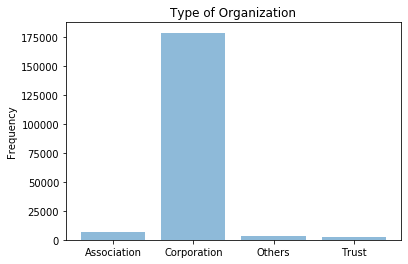

In [328]:
import matplotlib.pyplot as plt
objects = ('Association', 'Corporation', 'Others', 'Trust')
y_pos = np.arange(len(objects))

plt.bar(y_pos, orgtype, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.title('Type of Organization')

In [329]:
#percentage of parameters - we can delete disconintue_dispose25
add_bool=df[['discontinue_dispose25', 'material_diversion','local_chapt']]
((add_bool.sum().head())/len(df[['discontinue_dispose25']]))*100

discontinue_dispose25    1.480380
material_diversion       0.127985
local_chapt              5.257240
dtype: float64

In [330]:
df.columns

Index(['ein', 'name_org', 'tax_yr', 'city', 'state', 'org_form.association',
       'org_form.corp', 'org_form.other_form', 'org_form.trust',
       'formation_yr', 'gross_receipts', 'discontinue_dispose25',
       'voting_memb_ct', 'voting_indepmemb_ct', 'employee_tot_ct',
       'volunteer_tot_ct', 'rev_tot_prioryr', 'expense_tot_prioryr',
       'rev_less_expense_prioryr', 'asset_tot_beginyr',
       'liability_tot_beginyr', 'asset_net_beginyr', 'rev_tot_curyr',
       'expense_tot_curyr', 'rev_less_expense_curyr', 'asset_tot_endyr',
       'liability_tot_endyr', 'asset_net_endyr', 'material_diversion',
       'local_chapt', 'comp_currkeypersons_tot', 'cash_noninterest_endyr',
       'savingtempcash_endyr', 'pledges_net_endyr',
       'accountreceivable_net_endyr', 'invest_publicsec_endyr',
       'invest_othersec_endyr', 'invest_prog_endyr', 'asset_intangible_endyr',
       'asset_unrestrictnet_endyr', 'asset_temprestrictnet_endyr',
       'asset_permrestrictnet_endyr', 'code_A', '

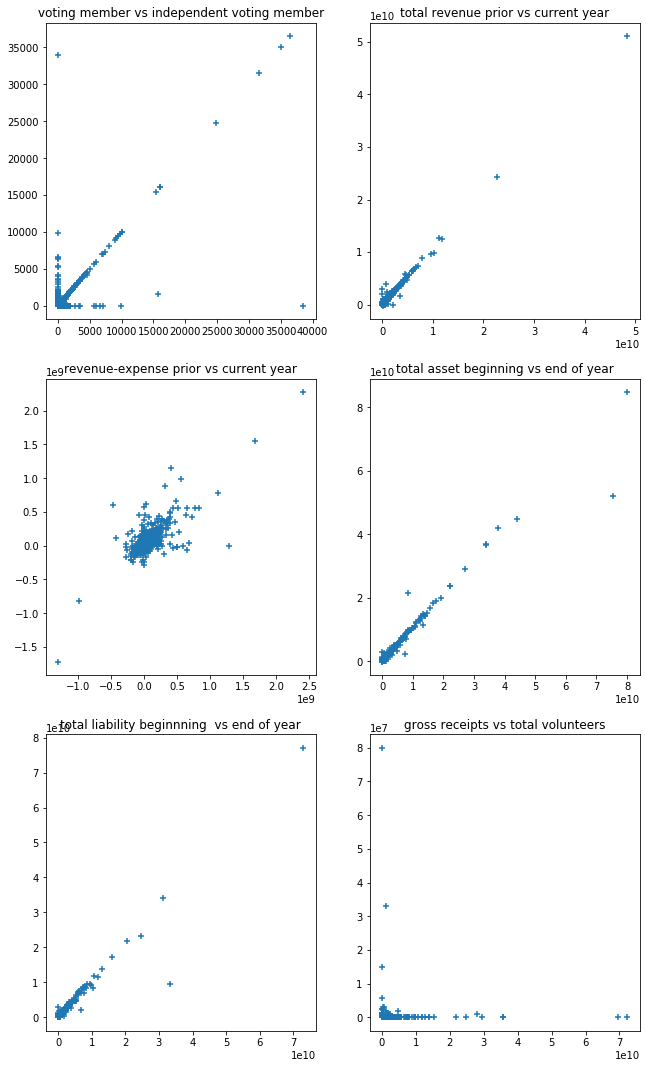

In [331]:
# looking to further clean the data; mostly looking at variables that we know that should be already related
plt.subplot(321)
plt.scatter(df['voting_memb_ct'], df['voting_indepmemb_ct'], marker='+')
plt.title('voting member vs independent voting member')

plt.subplot(322)
plt.scatter(df['rev_tot_prioryr'], df['rev_tot_curyr'], marker='+')
plt.title('total revenue prior vs current year')

plt.subplot(323)
plt.scatter(df['rev_less_expense_prioryr'], df['rev_less_expense_curyr'], marker='+')
plt.title('revenue-expense prior vs current year')

plt.subplot(324)
plt.scatter(df['asset_tot_beginyr'], df['asset_tot_endyr'], marker='+')
plt.title('total asset beginning vs end of year')

plt.subplot(325)
plt.scatter(df['liability_tot_beginyr'], df['liability_tot_endyr'], marker='+')
plt.title('total liability beginnning  vs end of year')

plt.subplot(326)
plt.scatter(df['gross_receipts'], df['volunteer_tot_ct'], marker='+')
plt.title('gross receipts vs total volunteers')

plt.subplots_adjust(bottom=1.5, right=1.5, top=5)
plt.show()

# ntee code

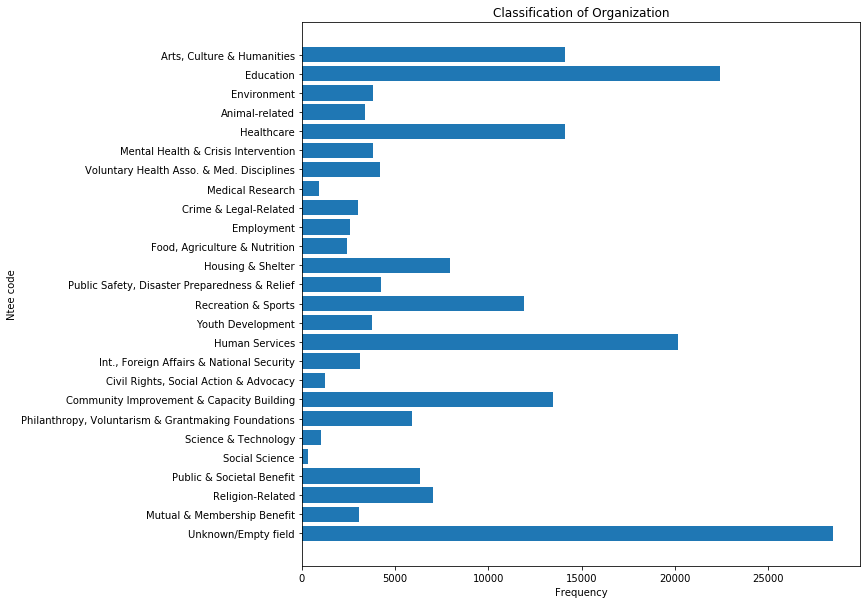

In [332]:
ntee_code=df[['code_A', 'code_B', 'code_C', 'code_D',
              'code_E', 'code_F', 'code_G', 'code_H', 
              'code_I', 'code_J', 'code_K','code_L', 
              'code_M', 'code_N', 'code_O', 'code_P', 
              'code_Q', 'code_R','code_S', 
              'code_T', 'code_U', 'code_V', 'code_W', 
              'code_X', 'code_Y', 'code_Z']]
ntee_code=ntee_code.sum()
objects = ('Arts, Culture & Humanities', 'Education', 'Environment', 'Animal-related',
          'Healthcare','Mental Health & Crisis Intervention', 'Voluntary Health Asso. & Med. Disciplines', 'Medical Research',
          'Crime & Legal-Related', 'Employment','Food, Agriculture & Nutrition','Housing & Shelter',
          'Public Safety, Disaster Preparedness & Relief','Recreation & Sports', 'Youth Development','Human Services',
          'Int., Foreign Affairs & National Security', 'Civil Rights, Social Action & Advocacy', 'Community Improvement & Capacity Building',
          'Philanthropy, Voluntarism & Grantmaking Foundations', 'Science & Technology','Social Science','Public & Societal Benefit',
          'Religion-Related', 'Mutual & Membership Benefit', 'Unknown/Empty field')
y_pos = np.arange(len(objects))

fig, ax = plt.subplots(figsize=(10,10))
ax.barh(y_pos, ntee_code, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(objects)
ax.invert_yaxis()
plt.ylabel('Ntee code')
plt.xlabel('Frequency')
plt.title('Classification of Organization')
plt.show()

In [333]:
v_ntee=df[[
              'code_A', 'code_B', 'code_C', 'code_D',
              'code_E', 'code_F', 'code_G', 'code_H', 
              'code_I', 'code_J', 'code_K','code_L', 
              'code_M', 'code_N', 'code_O', 'code_P', 
              'code_Q', 'code_R','code_S', 
              'code_T', 'code_U', 'code_V', 'code_W', 
              'code_X', 'code_Y', 'code_Z']]
v_ntee.columns = [col.replace('code_',' ') for col in v_ntee.columns]
v_ntee.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192991 entries, 0 to 202319
Data columns (total 26 columns):
 A    192991 non-null bool
 B    192991 non-null bool
 C    192991 non-null bool
 D    192991 non-null bool
 E    192991 non-null bool
 F    192991 non-null bool
 G    192991 non-null bool
 H    192991 non-null bool
 I    192991 non-null bool
 J    192991 non-null bool
 K    192991 non-null bool
 L    192991 non-null bool
 M    192991 non-null bool
 N    192991 non-null bool
 O    192991 non-null bool
 P    192991 non-null bool
 Q    192991 non-null bool
 R    192991 non-null bool
 S    192991 non-null bool
 T    192991 non-null bool
 U    192991 non-null bool
 V    192991 non-null bool
 W    192991 non-null bool
 X    192991 non-null bool
 Y    192991 non-null bool
 Z    192991 non-null bool
dtypes: bool(26)
memory usage: 6.3 MB


In [334]:
v_ntee.columns.str.split('_', expand=True)
v_ntee=v_ntee[v_ntee==1].stack().reset_index().drop(0,1)
v_ntee=v_ntee.drop(columns=['level_0'])
v_ntee['volunteer']=df[['volunteer_tot_ct']]
v_ntee.head()

,level_1,volunteer
0,W,8500.0
1,W,15.0
2,Y,9.0
3,N,32.0
4,S,250.0


In [335]:
v_ntee=v_ntee.rename(columns={'level_1': 'ntee_code'})
v_ntee['ntee_code']=v_ntee['ntee_code'].astype('category')
v_ntee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192812 entries, 0 to 192811
Data columns (total 2 columns):
ntee_code    192812 non-null category
volunteer    183825 non-null float64
dtypes: category(1), float64(1)
memory usage: 1.7 MB


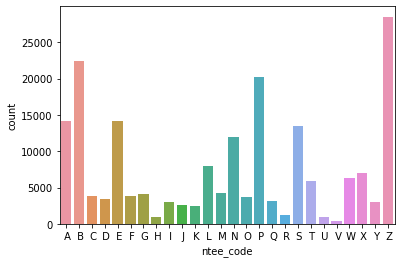

In [336]:
import seaborn as sns
sns.countplot(v_ntee['ntee_code']);

In [337]:
v_ntee['volunteer'].describe()

count    1.838250e+05
mean     1.233528e+03
std      2.060880e+05
min      1.000000e+00
25%      1.000000e+01
50%      2.800000e+01
75%      1.000000e+02
max      8.000000e+07
Name: volunteer, dtype: float64

In [338]:
v_ntee=v_ntee.loc[v_ntee['volunteer'].quantile(0.99)>v_ntee['volunteer']]
v_ntee['volunteer'].describe()

count    181982.000000
mean        129.623694
std         332.886607
min           1.000000
25%          10.000000
50%          26.000000
75%         100.000000
max        3697.000000
Name: volunteer, dtype: float64

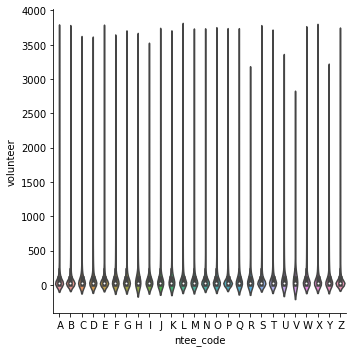

In [339]:
sns.catplot(x='ntee_code', y='volunteer', kind='violin', data=v_ntee)

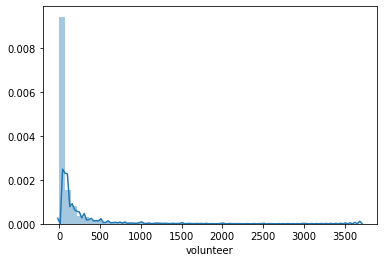

In [340]:
sns.distplot(v_ntee['volunteer'])

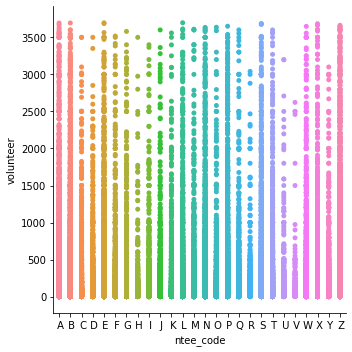

In [341]:
sns.catplot(x='ntee_code', y='volunteer', jitter=False, data=v_ntee)

In [342]:
irrelevant= [ 'liability_tot_endyr', 'comp_currkeypersons_tot',
       'cash_noninterest_endyr', 'savingtempcash_endyr', 'pledges_net_endyr',
       'accountreceivable_net_endyr', 'invest_publicsec_endyr',
       'invest_othersec_endyr', 'invest_prog_endyr', 'asset_intangible_endyr',
       'asset_unrestrictnet_endyr', 'asset_temprestrictnet_endyr',
       'asset_permrestrictnet_endyr', 'liability_tot_beginyr','rev_tot_prioryr', 
       'expense_tot_prioryr', 'asset_net_beginyr', 'rev_less_expense_prioryr', 
       'asset_tot_beginyr', 'material_diversion','discontinue_dispose25','voting_indepmemb_ct']
df=df.drop(columns=irrelevant)

In [343]:
df.columns

Index(['ein', 'name_org', 'tax_yr', 'city', 'state', 'org_form.association',
       'org_form.corp', 'org_form.other_form', 'org_form.trust',
       'formation_yr', 'gross_receipts', 'voting_memb_ct', 'employee_tot_ct',
       'volunteer_tot_ct', 'rev_tot_curyr', 'expense_tot_curyr',
       'rev_less_expense_curyr', 'asset_tot_endyr', 'asset_net_endyr',
       'local_chapt', 'code_A', 'code_B', 'code_C', 'code_D', 'code_E',
       'code_F', 'code_G', 'code_H', 'code_I', 'code_J', 'code_K', 'code_L',
       'code_M', 'code_N', 'code_O', 'code_P', 'code_Q', 'code_R', 'code_S',
       'code_T', 'code_U', 'code_V', 'code_W', 'code_X', 'code_Y', 'code_Z'],
      dtype='object')

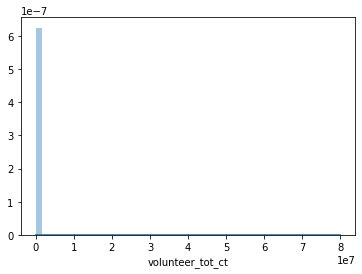

In [344]:
sns.distplot(df['volunteer_tot_ct'])

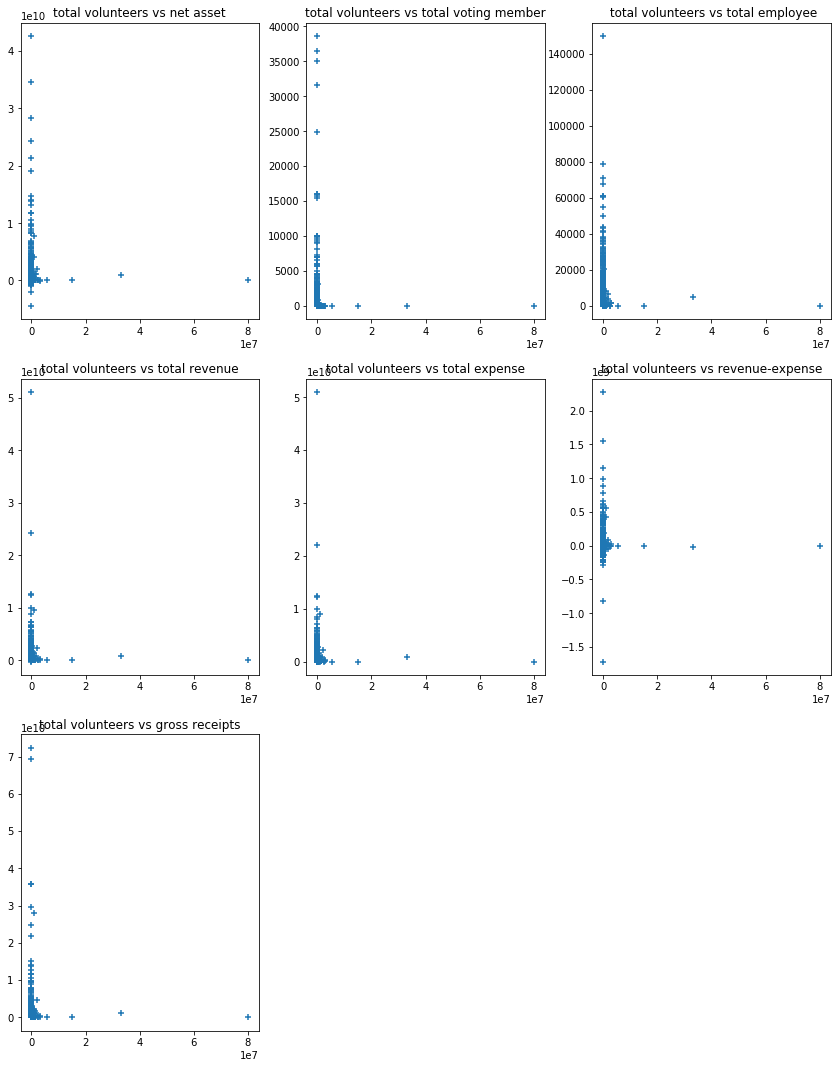

In [345]:
# looking to further clean the data; mostly looking at variables that we know that should be already related
plt.subplot(331)
plt.scatter(df['volunteer_tot_ct'], df['asset_net_endyr'], marker='+')
plt.title('total volunteers vs net asset')

plt.subplot(332)
plt.scatter( df['volunteer_tot_ct'], df['voting_memb_ct'], marker='+')
plt.title('total volunteers vs total voting member')

plt.subplot(333)
plt.scatter(df['volunteer_tot_ct'],df['employee_tot_ct'],  marker='+')
plt.title(' total volunteers vs total employee')

plt.subplot(334)
plt.scatter(df['volunteer_tot_ct'],df['rev_tot_curyr'],  marker='+')
plt.title('total volunteers vs total revenue')

plt.subplot(335)
plt.scatter( df['volunteer_tot_ct'], df['expense_tot_curyr'], marker='+')
plt.title('total volunteers vs total expense')

plt.subplot(336)
plt.scatter( df['volunteer_tot_ct'], df['rev_less_expense_curyr'],marker='+')
plt.title('total volunteers vs revenue-expense')

plt.subplot(337)
plt.scatter( df['volunteer_tot_ct'], df['gross_receipts'],marker='+')
plt.title('total volunteers vs gross receipts')

plt.subplots_adjust(bottom=1.5, right=2, top=5)
plt.show()

In [346]:
df['volunteer_tot_ct'].quantile(.99)

3800.0

In [347]:
df=df.loc[df['volunteer_tot_ct'].quantile(.99)> df['volunteer_tot_ct']]
df['volunteer_tot_ct'].describe()

count    191059.000000
mean        131.661618
std         338.188622
min           1.000000
25%          10.000000
50%          27.000000
75%         100.000000
max        3794.000000
Name: volunteer_tot_ct, dtype: float64

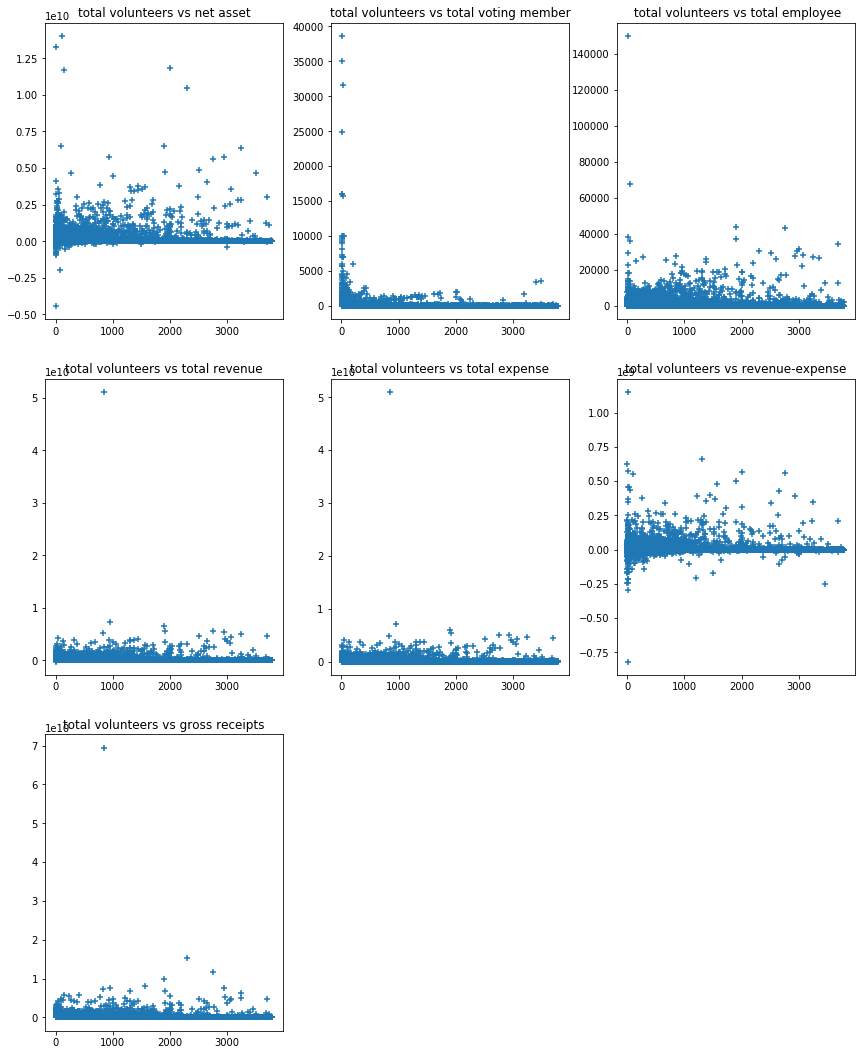

In [348]:
# should add gross receipts
# looking to further clean the data and see if there is any obvious correlation
plt.subplot(331)
plt.scatter(df['volunteer_tot_ct'], df['asset_net_endyr'], marker='+')
plt.title('total volunteers vs net asset')

plt.subplot(332)
plt.scatter( df['volunteer_tot_ct'], df['voting_memb_ct'], marker='+')
plt.title('total volunteers vs total voting member')

plt.subplot(333)
plt.scatter(df['volunteer_tot_ct'],df['employee_tot_ct'],  marker='+')
plt.title(' total volunteers vs total employee')

plt.subplot(334)
plt.scatter(df['volunteer_tot_ct'],df['rev_tot_curyr'],  marker='+')
plt.title('total volunteers vs total revenue')

plt.subplot(335)
plt.scatter( df['volunteer_tot_ct'], df['expense_tot_curyr'], marker='+')
plt.title('total volunteers vs total expense')

plt.subplot(336)
plt.scatter( df['volunteer_tot_ct'], df['rev_less_expense_curyr'],marker='+')
plt.title('total volunteers vs revenue-expense')

plt.subplot(337)
plt.scatter( df['volunteer_tot_ct'], df['gross_receipts'],marker='+')
plt.title('total volunteers vs gross receipts')

plt.subplots_adjust(bottom=1.5, right=2, top=5)
plt.show()

In [349]:
#There are many outliers that seem to be potentially related to mistakes
temp=df[(df['voting_memb_ct'])==(max(df['voting_memb_ct']))]
pd.concat([temp.iloc[:, 1:4], temp.iloc[:, 9:20]], axis=1)

,name_org,tax_yr,city,formation_yr,gross_receipts,voting_memb_ct,employee_tot_ct,volunteer_tot_ct,rev_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,asset_net_endyr,local_chapt
163563,ASSOCIATED CREDIT UNION OF TEXAS,2017.0,League City,1948,29883631.0,38574.0,214.0,7.0,29883631.0,27181751.0,2701880.0,408031793.0,400927921.0,True


From looking at their website, this may not be a mistake, considering that this is a credit union...

In [350]:
#There are many outliers that seem to be potentially related to mistakes
temp=df[(df['employee_tot_ct'])==(max(df['employee_tot_ct']))]
pd.concat([temp.iloc[:, 1:4], temp.iloc[:, 9:20]], axis=1)

,name_org,tax_yr,city,formation_yr,gross_receipts,voting_memb_ct,employee_tot_ct,volunteer_tot_ct,rev_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,asset_net_endyr,local_chapt
6883,BROCKTON 21ST CENTURY CORPORATION,2017.0,BROCKTON,1993,1050060.0,16.0,149672.0,3.0,149140.0,295140.0,-146000.0,22778061.0,16151281.0,False


B21 is in Brockton, Massachusetts and they seem to be involved with city planning and business at the city-level... Maybe the employee number makes sense?

In [351]:
temp=df[(df['rev_tot_curyr'])==(max(df['rev_tot_curyr']))]
pd.concat([temp.iloc[:, 1:4], temp.iloc[:, 9:20]], axis=1)

,name_org,tax_yr,city,formation_yr,gross_receipts,voting_memb_ct,employee_tot_ct,volunteer_tot_ct,rev_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,asset_net_endyr,local_chapt
192891,KAISER FOUNDATION HEALTH PLAN INC,2016.0,OAKLAND,1955,6.944205e+10,14.0,27375.0,845.0,5.106572e+10,5.097767e+10,88046347.0,1.993158e+10,2.681941e+09,False


This is Kaiser Permanente so the revenue makes sense

In [352]:
temp=df[(df['expense_tot_curyr'])==(max(df['expense_tot_curyr']))]
pd.concat([temp.iloc[:, 1:4], temp.iloc[:, 9:20]], axis=1)

,name_org,tax_yr,city,formation_yr,gross_receipts,voting_memb_ct,employee_tot_ct,volunteer_tot_ct,rev_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,asset_net_endyr,local_chapt
192891,KAISER FOUNDATION HEALTH PLAN INC,2016.0,OAKLAND,1955,6.944205e+10,14.0,27375.0,845.0,5.106572e+10,5.097767e+10,88046347.0,1.993158e+10,2.681941e+09,False


Again, this is Kaiser Permanente.

In [353]:
temp=df[(df['rev_less_expense_curyr'])==(max(df['rev_less_expense_curyr']))]
pd.concat([temp.iloc[:, 1:4], temp.iloc[:, 9:20]], axis=1)

,name_org,tax_yr,city,formation_yr,gross_receipts,voting_memb_ct,employee_tot_ct,volunteer_tot_ct,rev_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,asset_net_endyr,local_chapt
50076,NATIONAL PHILANTHROPIC TRUST,2017.0,JENKINTOWN,1996,1.950307e+09,13.0,55.0,12.0,1.950307e+09,800450520.0,1.149856e+09,4.173265e+09,4.113914e+09,False


This is a huge public charity.

In [354]:
temp=df[(df['rev_less_expense_curyr'])==(min(df['rev_less_expense_curyr']))]
pd.concat([temp.iloc[:, 1:4], temp.iloc[:, 9:20]], axis=1)

,name_org,tax_yr,city,formation_yr,gross_receipts,voting_memb_ct,employee_tot_ct,volunteer_tot_ct,rev_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,asset_net_endyr,local_chapt
118295,Catholic Health Initiatives,2017.0,Englewood,1996,2.342629e+09,11.0,3446.0,10.0,2.303440e+09,3.121267e+09,-817827265.0,6.980906e+09,-4.419198e+09,True


Catholic Health Initiatives Annual report for 2017 seems to be different from what was reported here. They claim that they have 91,000 employees, where 4,000 is employed and advanced physicians. So, the employee total count must be corresponding to that. Additionally, $15 billion was the number they reported as a total revenue in 2017, but we see that the number is not close to the number reported above. This must be a mistake, considering that their revenue is in trillion range. Ultimately, a lot of these larger organizations with high number of revenues, expenses, assets, and employees will not help Charity Quest in the short-run. I will focus on smaller organizations by taking the top 5% out of the total data and also the bottom 5% of the revenue - expense parameter and net asset parameters. Since the order matters when we move these dataset, I will remove outliers of net asset, revenue-expense first since there are more outliers.

In [355]:
df_backup=df.copy()

In [356]:
df=df_backup.copy()

In [357]:
df=df.loc[(df['rev_less_expense_curyr'].quantile(0.95)> df['rev_less_expense_curyr']) & (df['rev_less_expense_curyr'].quantile(.05)< df['rev_less_expense_curyr'])]
df=df.loc[(df['asset_net_endyr'].quantile(.95)> df['asset_net_endyr']) & (df['rev_less_expense_curyr'].quantile(.05)< df['rev_less_expense_curyr'])]

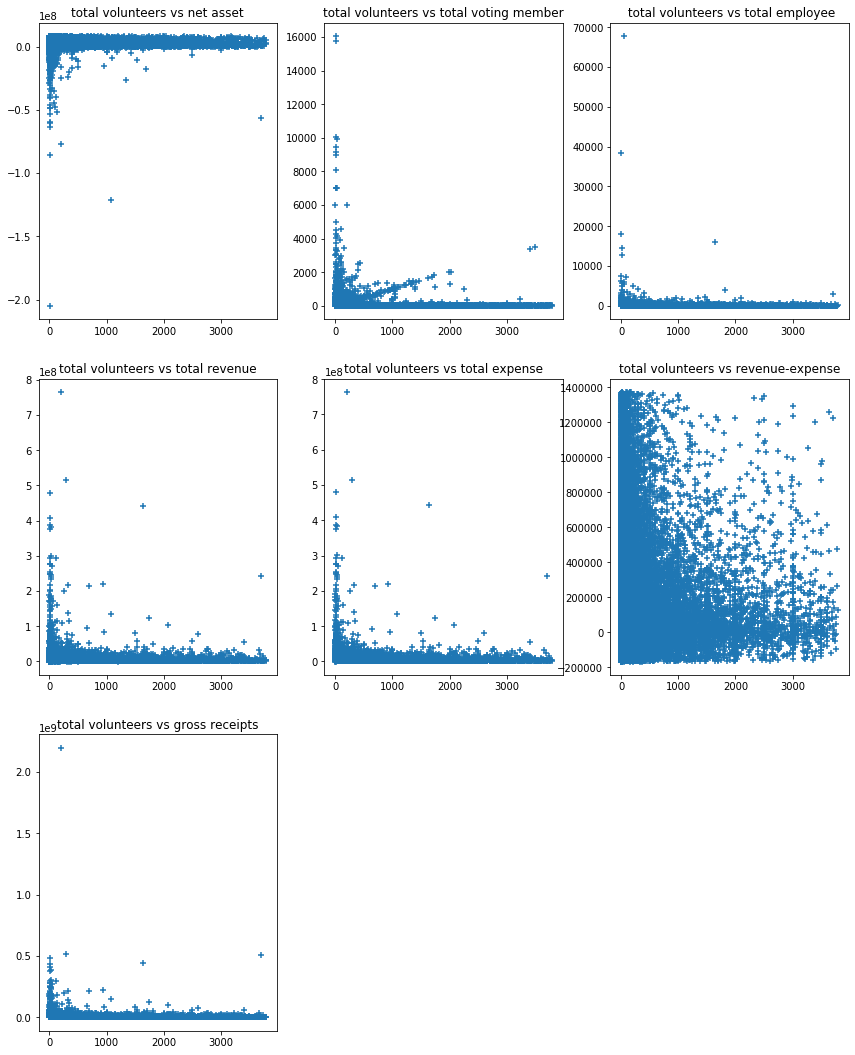

In [358]:
plt.subplot(331)
plt.scatter(df['volunteer_tot_ct'], df['asset_net_endyr'], marker='+')
plt.title('total volunteers vs net asset')

plt.subplot(332)
plt.scatter( df['volunteer_tot_ct'], df['voting_memb_ct'], marker='+')
plt.title('total volunteers vs total voting member')

plt.subplot(333)
plt.scatter(df['volunteer_tot_ct'],df['employee_tot_ct'],  marker='+')
plt.title(' total volunteers vs total employee')

plt.subplot(334)
plt.scatter(df['volunteer_tot_ct'],df['rev_tot_curyr'],  marker='+')
plt.title('total volunteers vs total revenue')

plt.subplot(335)
plt.scatter( df['volunteer_tot_ct'], df['expense_tot_curyr'], marker='+')
plt.title('total volunteers vs total expense')

plt.subplot(336)
plt.scatter( df['volunteer_tot_ct'], df['rev_less_expense_curyr'],marker='+')
plt.title('total volunteers vs revenue-expense')

plt.subplot(337)
plt.scatter( df['volunteer_tot_ct'], df['gross_receipts'],marker='+')
plt.title('total volunteers vs gross receipts')

plt.subplots_adjust(bottom=1.5, right=2, top=5)
plt.show()

In [359]:
# net asset still has outliers in the negative directions - so I will remove additional bottom 5%, which removes bottom 10% total 
df=df.loc[df['asset_net_endyr'].quantile(.05)< df['asset_net_endyr']]

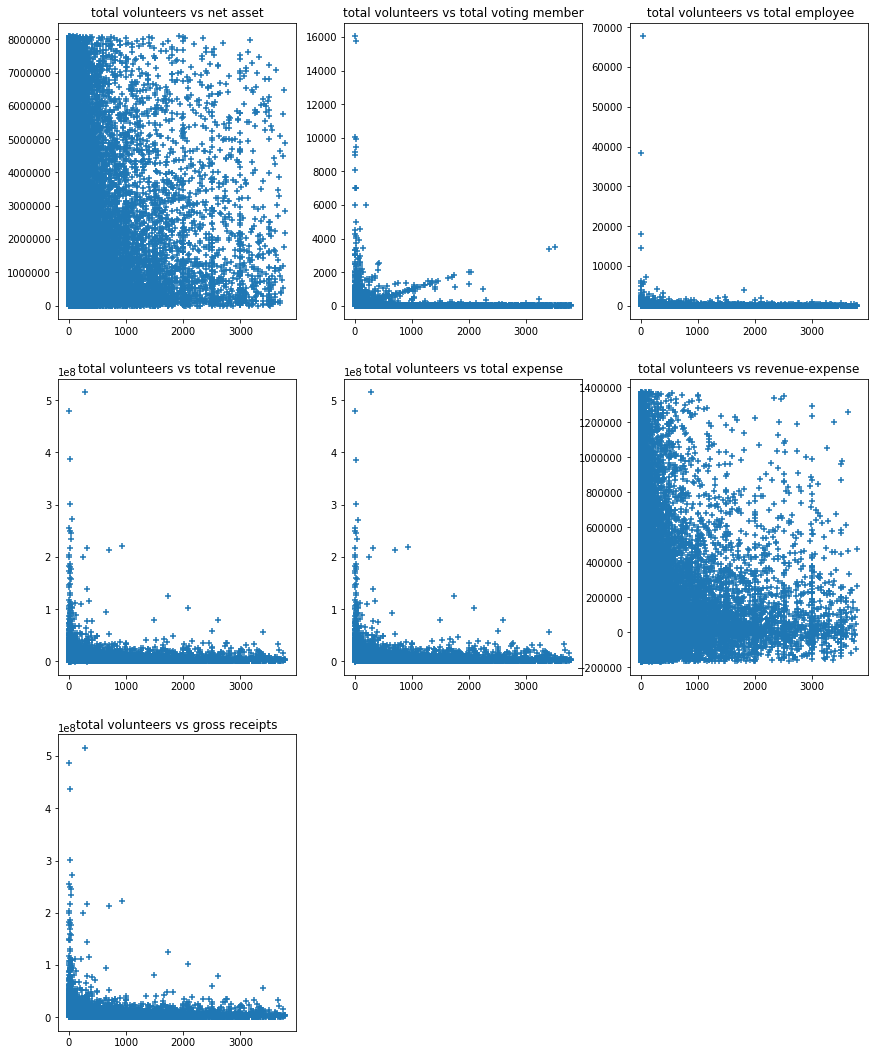

In [360]:
plt.subplot(331)
plt.scatter(df['volunteer_tot_ct'], df['asset_net_endyr'], marker='+')
plt.title('total volunteers vs net asset')

plt.subplot(332)
plt.scatter( df['volunteer_tot_ct'], df['voting_memb_ct'], marker='+')
plt.title('total volunteers vs total voting member')

plt.subplot(333)
plt.scatter(df['volunteer_tot_ct'],df['employee_tot_ct'],  marker='+')
plt.title(' total volunteers vs total employee')

plt.subplot(334)
plt.scatter(df['volunteer_tot_ct'],df['rev_tot_curyr'],  marker='+')
plt.title('total volunteers vs total revenue')

plt.subplot(335)
plt.scatter( df['volunteer_tot_ct'], df['expense_tot_curyr'], marker='+')
plt.title('total volunteers vs total expense')

plt.subplot(336)
plt.scatter( df['volunteer_tot_ct'], df['rev_less_expense_curyr'],marker='+')
plt.title('total volunteers vs revenue-expense')

plt.subplot(337)
plt.scatter( df['volunteer_tot_ct'], df['gross_receipts'],marker='+')
plt.title('total volunteers vs gross receipts')

plt.subplots_adjust(bottom=1.5, right=2, top=5)
plt.show()

In [361]:
df['rev_tot_curyr'].describe()

count    1.480990e+05
mean     1.215239e+06
std      4.742285e+06
min     -2.088120e+05
25%      1.617160e+05
50%      3.398330e+05
75%      9.090425e+05
max      5.154313e+08
Name: rev_tot_curyr, dtype: float64

In [362]:
df['expense_tot_curyr'].describe()

count    1.480990e+05
mean     1.148925e+06
std      4.704287e+06
min     -2.665840e+05
25%      1.404440e+05
50%      3.090640e+05
75%      8.199860e+05
max      5.155141e+08
Name: expense_tot_curyr, dtype: float64

In [363]:
# deleting the top 1% of voting and employee total count
df=df.loc[df['voting_memb_ct'].quantile(.99)> df['voting_memb_ct']]
df=df.loc[df['employee_tot_ct'].quantile(.99)> df['employee_tot_ct']]

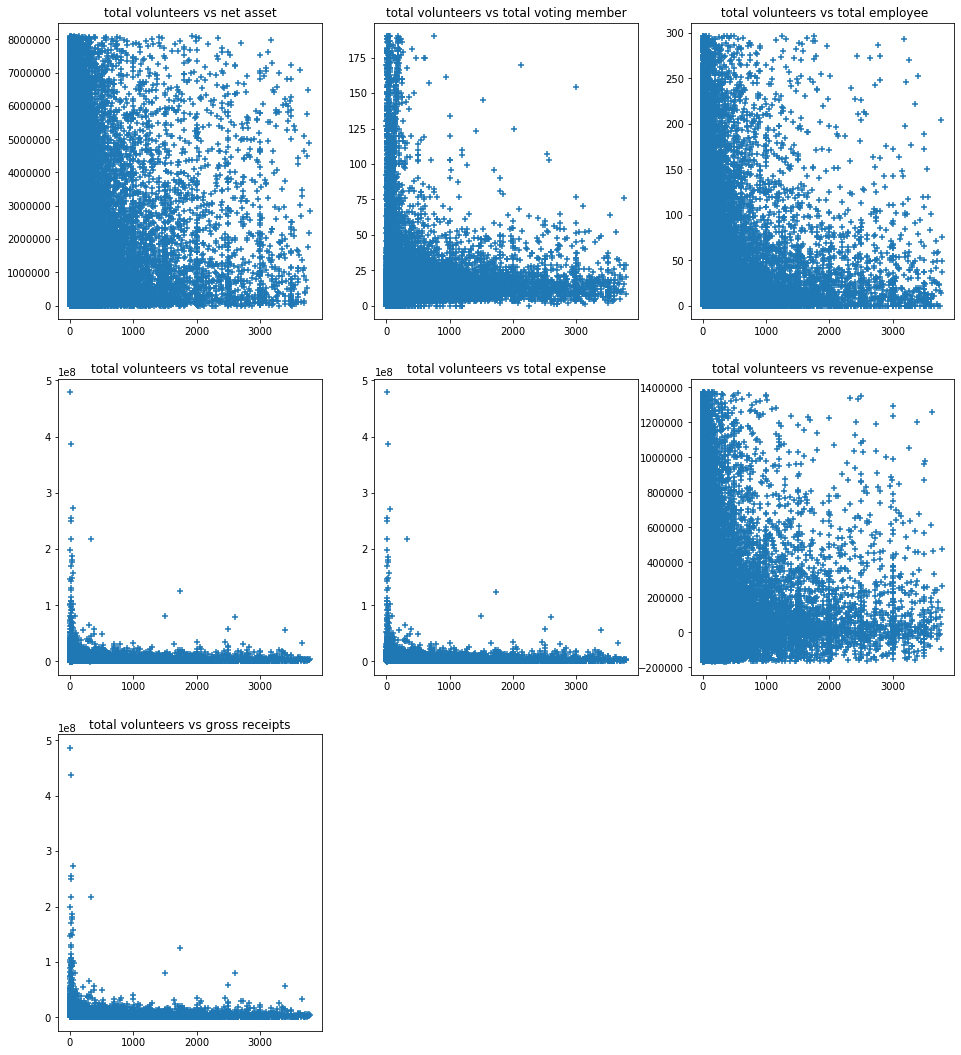

In [364]:
plt.subplot(331)
plt.scatter(df['volunteer_tot_ct'], df['asset_net_endyr'], marker='+')
plt.title('total volunteers vs net asset')

plt.subplot(332)
plt.scatter( df['volunteer_tot_ct'], df['voting_memb_ct'], marker='+')
plt.title('total volunteers vs total voting member')

plt.subplot(333)
plt.scatter(df['volunteer_tot_ct'],df['employee_tot_ct'],  marker='+')
plt.title(' total volunteers vs total employee')

plt.subplot(334)
plt.scatter(df['volunteer_tot_ct'],df['rev_tot_curyr'],  marker='+')
plt.title('total volunteers vs total revenue')

plt.subplot(335)
plt.scatter( df['volunteer_tot_ct'], df['expense_tot_curyr'], marker='+')
plt.title('total volunteers vs total expense')

plt.subplot(336)
plt.scatter( df['volunteer_tot_ct'], df['rev_less_expense_curyr'],marker='+')
plt.title('total volunteers vs revenue-expense')

plt.subplot(337)
plt.scatter( df['volunteer_tot_ct'], df['gross_receipts'],marker='+')
plt.title('total volunteers vs gross receipts')

plt.subplots_adjust(bottom=1.5, right=2.2, top=5)
plt.show()

In [365]:
# deleting the top 5% of gross receipts and revenue total - only taking renvenue instead of expense because the values are very similar
df=df.loc[df['gross_receipts'].quantile(.99)> df['gross_receipts']]
df=df.loc[df['rev_tot_curyr'].quantile(.99)> df['rev_tot_curyr']]

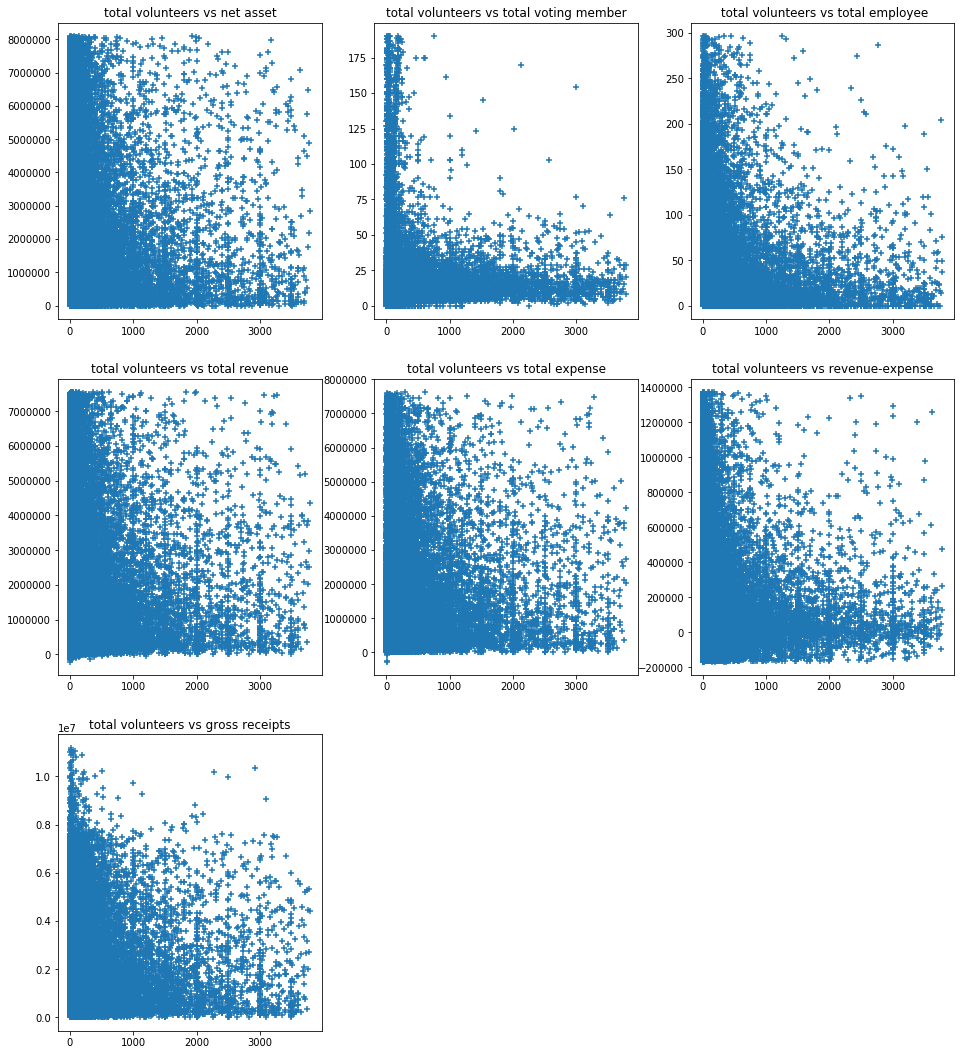

In [366]:
plt.subplot(331)
plt.scatter(df['volunteer_tot_ct'], df['asset_net_endyr'], marker='+')
plt.title('total volunteers vs net asset')

plt.subplot(332)
plt.scatter( df['volunteer_tot_ct'], df['voting_memb_ct'], marker='+')
plt.title('total volunteers vs total voting member')

plt.subplot(333)
plt.scatter(df['volunteer_tot_ct'],df['employee_tot_ct'],  marker='+')
plt.title(' total volunteers vs total employee')

plt.subplot(334)
plt.scatter(df['volunteer_tot_ct'],df['rev_tot_curyr'],  marker='+')
plt.title('total volunteers vs total revenue')

plt.subplot(335)
plt.scatter( df['volunteer_tot_ct'], df['expense_tot_curyr'], marker='+')
plt.title('total volunteers vs total expense')

plt.subplot(336)
plt.scatter( df['volunteer_tot_ct'], df['rev_less_expense_curyr'],marker='+')
plt.title('total volunteers vs revenue-expense')

plt.subplot(337)
plt.scatter( df['volunteer_tot_ct'], df['gross_receipts'],marker='+')
plt.title('total volunteers vs gross receipts')

plt.subplots_adjust(bottom=1.5, right=2.2, top=5)
plt.show()

The data does look better... It let's split this into training and testing sets

In [367]:
from sklearn.model_selection import StratifiedShuffleSplit

# Divide them into given bins to ensure that the number of ratings distribution represents the train and test sets
bins = [0, 10, 50, 100, 5000, np.inf]
labels=[1, 2, 3, 4, 5]
# create a new column containing the ratings bin the game is associated with
df['volunteer_tot_ct_cut'] = pd.cut(df['volunteer_tot_ct'], bins=bins, labels=labels)

# split data into training (80%) and testing (20%) sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ind, test_ind in split.split(df, df['volunteer_tot_ct_cut']):
    train_set, test_set = df.iloc[train_ind], df.iloc[test_ind]

test_label = test_set['volunteer_tot_ct'].copy()
test_identity = test_set[['name_org', 'ein']].copy()
test_set = test_set.drop(columns=['volunteer_tot_ct_cut','volunteer_tot_ct','name_org','tax_yr', 'ein', 'city', 'state'])

train_label = train_set['volunteer_tot_ct'].copy()
train_identity = train_set[['name_org', 'ein']].copy()
train_set_binned = train_set['volunteer_tot_ct_cut'].copy() # label identifying the ratings bin the game occupies
train_set = train_set.drop(columns=['volunteer_tot_ct_cut','volunteer_tot_ct','name_org','tax_yr', 'ein', 'city', 'state']) 
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28451 entries, 37945 to 1540
Data columns (total 40 columns):
org_form.association      28451 non-null bool
org_form.corp             28451 non-null bool
org_form.other_form       28451 non-null bool
org_form.trust            28451 non-null bool
formation_yr              28451 non-null int32
gross_receipts            28451 non-null float64
voting_memb_ct            28451 non-null float64
employee_tot_ct           28451 non-null float64
rev_tot_curyr             28451 non-null float64
expense_tot_curyr         28451 non-null float64
rev_less_expense_curyr    28451 non-null float64
asset_tot_endyr           28451 non-null float64
asset_net_endyr           28451 non-null float64
local_chapt               28451 non-null bool
code_A                    28451 non-null bool
code_B                    28451 non-null bool
code_C                    28451 non-null bool
code_D                    28451 non-null bool
code_E                    28451 non

In [369]:
df.to_sql('clean_data', w, if_exists='replace', index=False)

query=''' SELECT *
FROM clean_Data
'''
df = pd.read_sql_query(query, w)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000248B6846108>,
      dtype=object)

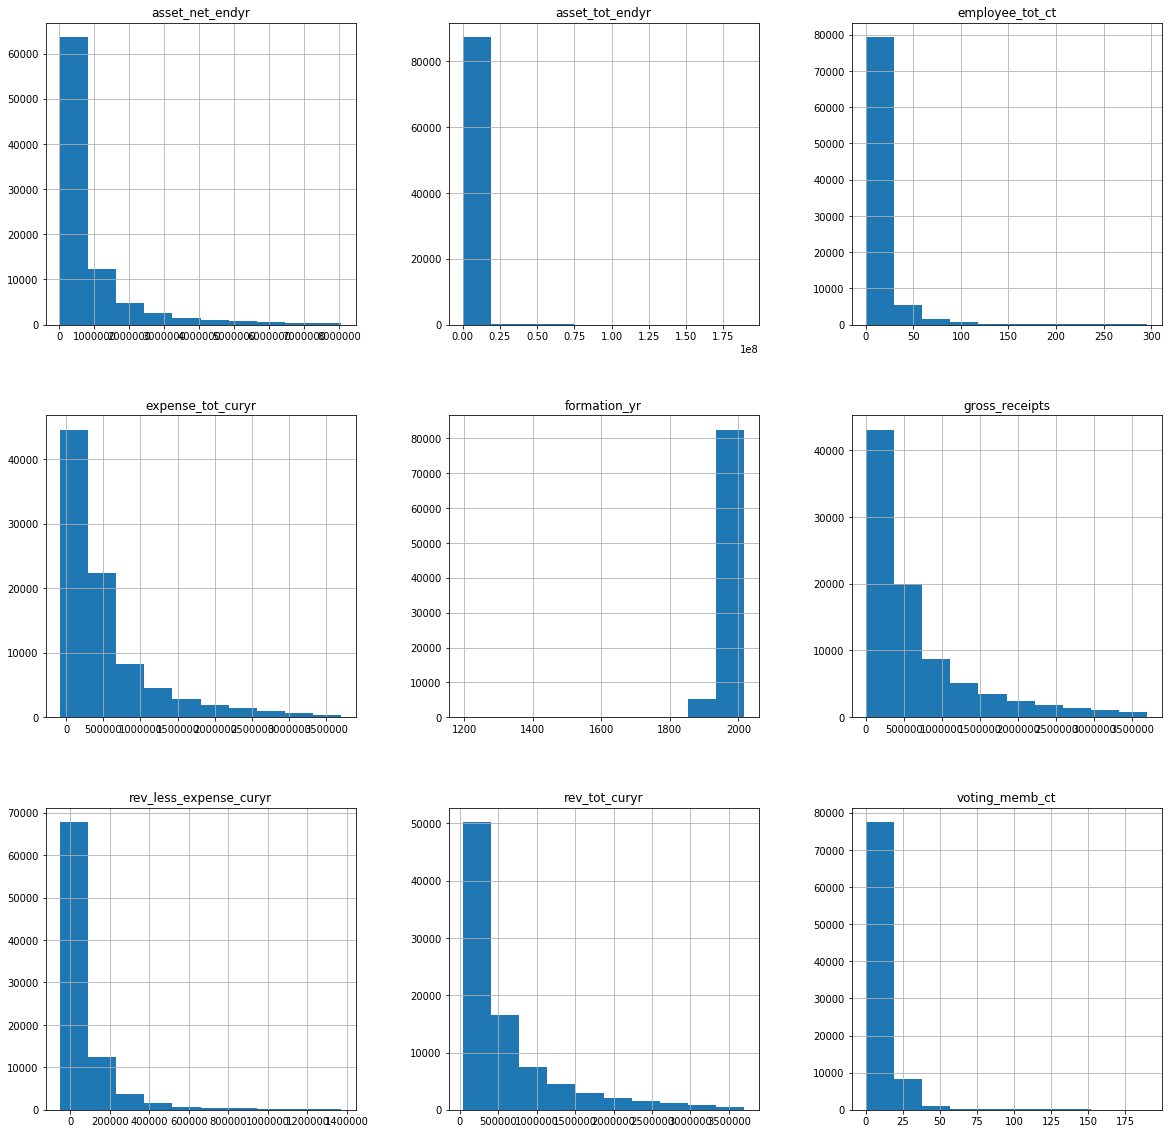

In [403]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import skew
from scipy.stats import boxcox

class SkewCorrector(BaseEstimator, TransformerMixin):
    
    def __init__(self, skew_bound=0.2): # skew_bound is amount of skew that is acceptable
        self.skew_bound = skew_bound
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_val = X.to_numpy()
        # different distributions require different transforms; indicies are defined below for specific data types
        ind_skewed = np.absolute(skew(X_val)) > self.skew_bound
        ind_right_skew = skew(X_val) > 0
        ind_left_skew = skew(X_val) < 0
        # ind_no_zeros = [0 not in X_val[:,col] for col in np.arange(X_val.shape[1])]
        ind_has_zeros = [0 in X_val[:,col] for col in np.arange(X_val.shape[1])]

        # # transform right skewed data that contains zero values with log plus one
        X_trans = np.log1p(X_val[:,ind_skewed & ind_right_skew & ind_has_zeros])
        X_val[:,ind_skewed * ind_right_skew * ind_has_zeros] = X_trans

        # # transform left skewed data that contains zero values by increasing power incrementally
        for pwr in range(2, 5): #arbitarily set the power limit to 5; maybe make this a user-defined parameter?
            X_trans = X_val[:,ind_skewed * ind_left_skew * ind_has_zeros]**pwr

        X_val[:,ind_skewed * ind_left_skew * ind_has_zeros] = X_trans
        
        # Update the input data frame with transformed values
        X_out = pd.DataFrame(X_val, index=X.index, columns=X.columns)
        return X_out
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('trans_skew', SkewCorrector(skew_bound=0.2)),
    ('std_scaler', StandardScaler())
])
numeric_feat = train_set.dtypes[train_set.dtypes == 'float64'].index
cat_feat = train_set.dtypes[train_set.dtypes != 'float64'].index

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numeric_feat)
])
train_set_processed = train_set.copy()
# Correct negative values by adding constants
for feat_idx, feat in enumerate(numeric_feat):
    if (train_set_processed[feat]<0).any()==True:
        train_set_processed[feat]= train_set_processed[feat]+ abs(min(train_set_processed[feat]))

train_set_processed[numeric_feat] = full_pipeline.fit_transform(train_set_processed[numeric_feat])

train_set[numeric_feat].hist(bins=10, figsize=(20,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000246F1A28988>,
      dtype=object)

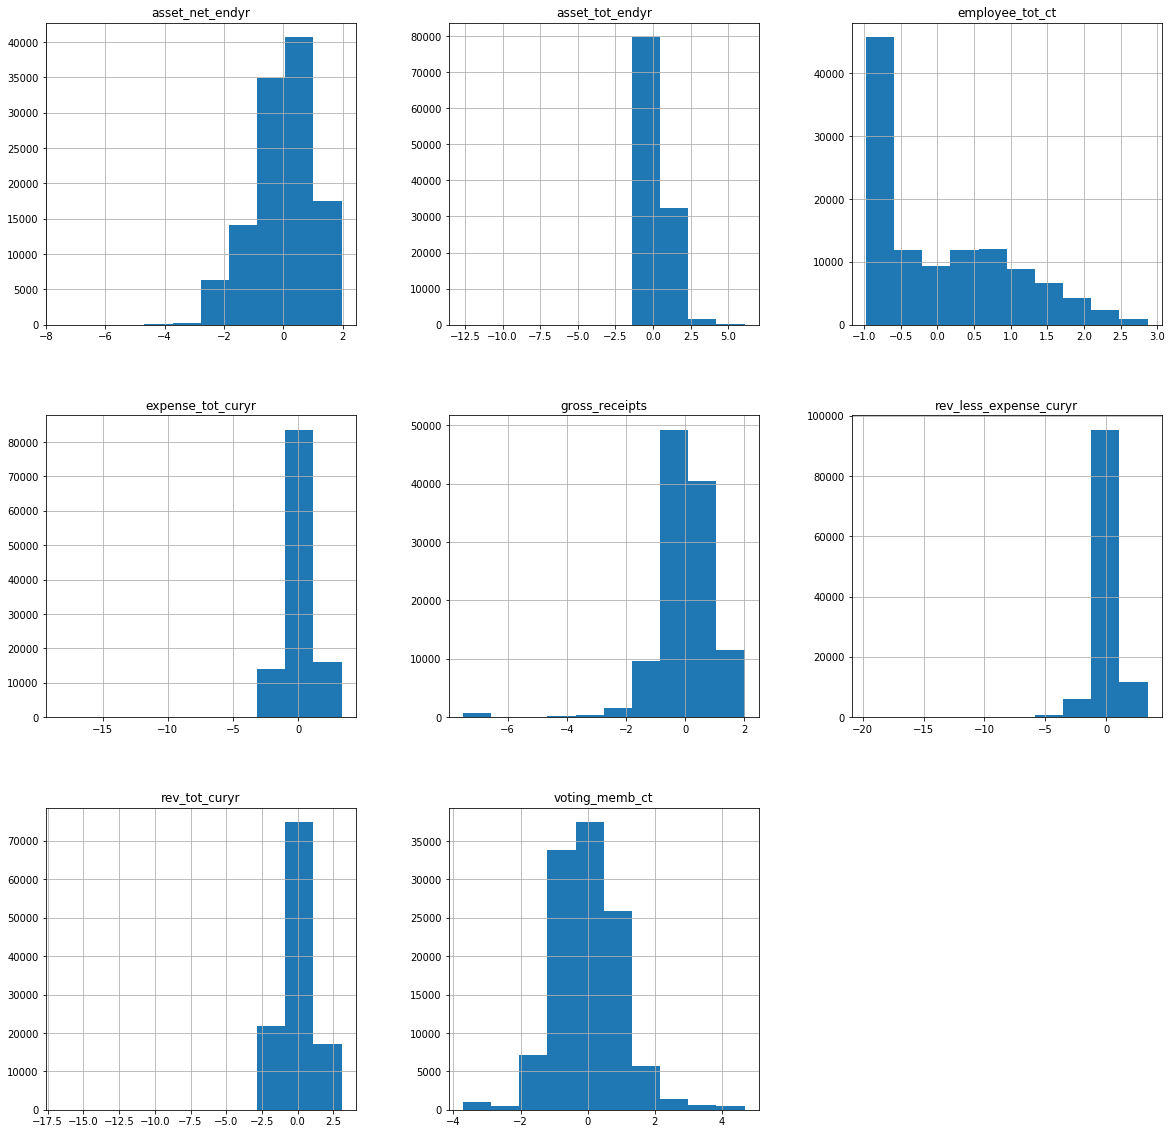

In [371]:
train_set_processed[numeric_feat].hist(bins=10, figsize=(20,20))

Not too bad, but note that some variables are skewed because the original data was heavily skewed. It is possible to delete more outliners.

In [372]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

def init_cv_gen():
    '''Helper function that returns a generator for cross-validation'''
    skf = StratifiedKFold(5, shuffle=True, random_state=42).split(train_set_processed, train_set_binned)
    return skf

def cv_score(estimator):
    '''Generates cross validation scores; used to keep code clean when testing different models (estimator)'''
    cv = init_cv_gen()
    cv_score = cross_val_score(estimator=estimator, X=train_set_processed, y=train_label, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
    return cv_score

def show_cv_result(scores):
    '''Print mean and standard deviation of an array of cross validation scores'''
    print(f'Cross validation mean score is : {np.mean(scores)} ± {np.std(scores)}')

In [373]:
#%% Linear Model
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 123.38903422813273 ± 1.2252080698776688


In [374]:
from sklearn.linear_model import ElasticNet

ENreg = ElasticNet()
ENreg.fit(train_set_processed, train_label)

ENscores = cv_score(ENreg)
show_cv_result(-ENscores)

Cross validation mean score is : 123.33547919745342 ± 1.2403355516197618


In [375]:
df['volunteer_tot_ct'].describe()

count    142252.000000
mean        110.143850
std         286.361606
min           1.000000
25%          10.000000
50%          25.000000
75%          90.000000
max        3789.000000
Name: volunteer_tot_ct, dtype: float64

The score is not as good as expected. Considering that the error is more than the 75% of data. Let's remove outliers further

In [376]:
df['asset_net_endyr'].describe()

count    1.422520e+05
mean     8.605143e+05
std      1.309760e+06
min     -5.714000e+03
25%      1.028840e+05
50%      3.479175e+05
75%      9.876820e+05
max      8.090158e+06
Name: asset_net_endyr, dtype: float64

In [377]:
df['voting_memb_ct'].describe()

count    142252.000000
mean         11.750654
std          12.610833
min           0.000000
25%           6.000000
50%           9.000000
75%          14.000000
max         190.000000
Name: voting_memb_ct, dtype: float64

In [378]:
df['employee_tot_ct'].describe()

count    142252.000000
mean         13.016309
std          28.930726
min           0.000000
25%           0.000000
50%           2.000000
75%          12.000000
max         296.000000
Name: employee_tot_ct, dtype: float64

In [379]:
df['rev_tot_curyr'].describe()

count    1.422520e+05
mean     7.663469e+05
std      1.149742e+06
min     -2.088120e+05
25%      1.575955e+05
50%      3.273615e+05
75%      8.233448e+05
max      7.552882e+06
Name: rev_tot_curyr, dtype: float64

In [380]:
df['expense_tot_curyr'].describe()

count    1.422520e+05
mean     7.077173e+05
std      1.091700e+06
min     -2.665840e+05
25%      1.366830e+05
50%      2.978330e+05
75%      7.435330e+05
max      7.627666e+06
Name: expense_tot_curyr, dtype: float64

In [381]:
df['rev_less_expense_curyr'].describe()

count    1.422520e+05
mean     5.862960e+04
std      1.665264e+05
min     -1.673130e+05
25%     -1.178325e+04
50%      1.211600e+04
75%      6.886375e+04
max      1.372669e+06
Name: rev_less_expense_curyr, dtype: float64

In [382]:
df['gross_receipts'].describe()

count    1.422520e+05
mean     8.616358e+05
std      1.248071e+06
min      0.000000e+00
25%      2.024692e+05
50%      3.802005e+05
75%      9.432705e+05
max      1.118976e+07
Name: gross_receipts, dtype: float64

In [437]:
query=''' SELECT *
FROM clean_data
'''
df=pd.read_sql_query(query, w)

## Further data cleaning

In [432]:
df=df.apply(lambda x: x.astype(float) if (x.dtype=='int32') else x)
df['formation_yr'].describe()

count    142252.000000
mean       1986.242099
std          27.478250
min        1057.000000
25%        1975.000000
50%        1993.000000
75%        2006.000000
max        2018.000000
Name: formation_yr, dtype: float64

In [438]:
df['formation_yr']=df[['formation_yr','tax_yr']].apply(lambda x: 2018-x['formation_yr'] if x['formation_yr']!=0 else 2018-x['tax_yr'], axis=1) 
df=df.rename(columns={'formation_yr': 'formation_dur'})
df['formation_dur'].describe()

count    142252.000000
mean         31.757901
std          27.478250
min           0.000000
25%          12.000000
50%          25.000000
75%          43.000000
max         961.000000
Name: formation_dur, dtype: float64

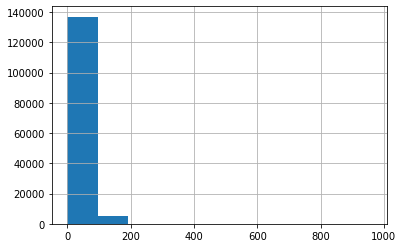

In [439]:
df['formation_dur'].hist(bins=10)

In [440]:
df['formation_dur']=df[['formation_dur','tax_yr']].apply(lambda x: 2020-x['tax_yr'] if x['formation_dur']>800 else x['formation_dur'], axis=1) 
df['formation_dur'].describe()

count    142252.000000
mean         31.734000
std          27.126208
min           0.000000
25%          12.000000
50%          25.000000
75%          43.000000
max         371.000000
Name: formation_dur, dtype: float64

In [441]:
df=df.loc[df['asset_net_endyr'].quantile(.05)< df['asset_net_endyr']]
df=df.loc[df['asset_net_endyr'].quantile(.95)> df['asset_net_endyr']]

df=df.loc[df['rev_tot_curyr'].quantile(.05)< df['rev_tot_curyr']]
df=df.loc[df['rev_tot_curyr'].quantile(.95)> df['rev_tot_curyr']]

df=df.loc[df['rev_less_expense_curyr'].quantile(.10)< df['rev_less_expense_curyr']]

df=df.loc[df['gross_receipts'].quantile(.95)> df['gross_receipts']]

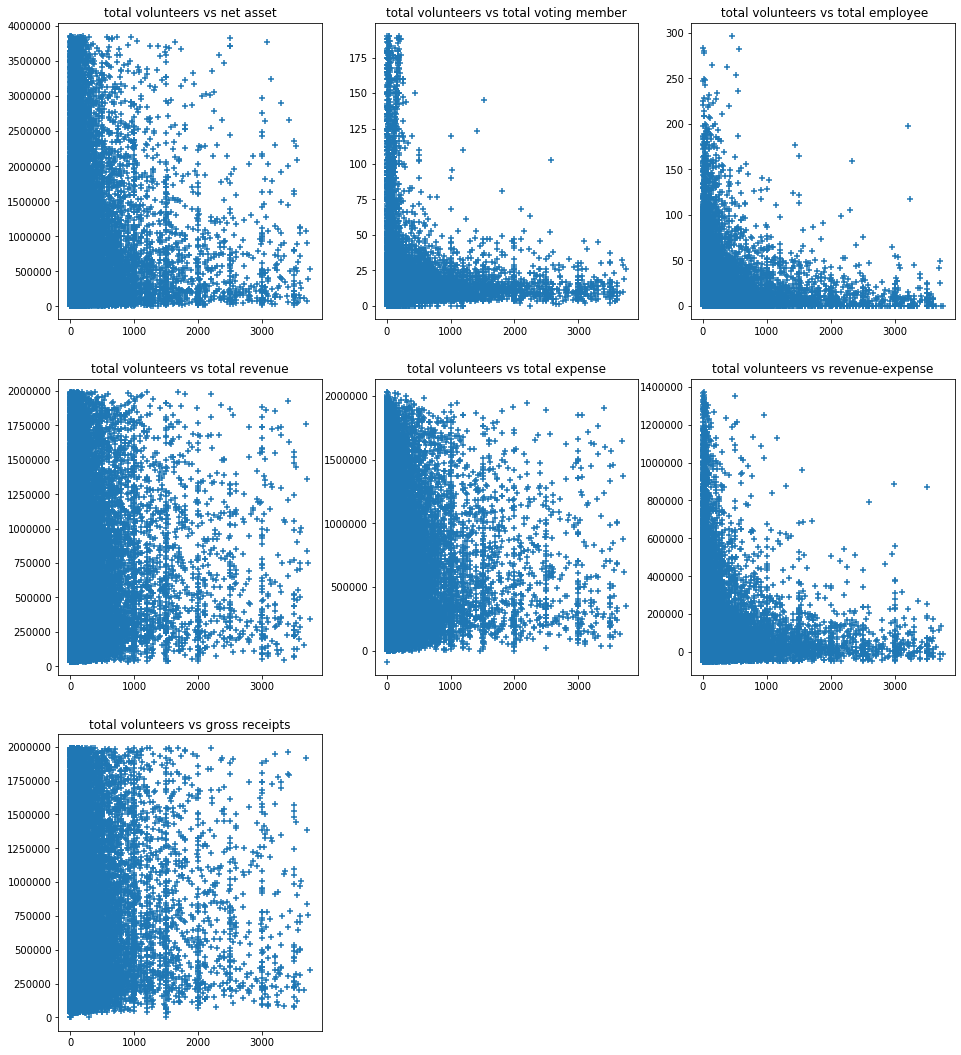

In [442]:
plt.subplot(331)
plt.scatter(df['volunteer_tot_ct'], df['asset_net_endyr'], marker='+')
plt.title('total volunteers vs net asset')

plt.subplot(332)
plt.scatter( df['volunteer_tot_ct'], df['voting_memb_ct'], marker='+')
plt.title('total volunteers vs total voting member')

plt.subplot(333)
plt.scatter(df['volunteer_tot_ct'],df['employee_tot_ct'],  marker='+')
plt.title(' total volunteers vs total employee')

plt.subplot(334)
plt.scatter(df['volunteer_tot_ct'],df['rev_tot_curyr'],  marker='+')
plt.title('total volunteers vs total revenue')

plt.subplot(335)
plt.scatter( df['volunteer_tot_ct'], df['expense_tot_curyr'], marker='+')
plt.title('total volunteers vs total expense')

plt.subplot(336)
plt.scatter( df['volunteer_tot_ct'], df['rev_less_expense_curyr'],marker='+')
plt.title('total volunteers vs revenue-expense')

plt.subplot(337)
plt.scatter( df['volunteer_tot_ct'], df['gross_receipts'],marker='+')
plt.title('total volunteers vs gross receipts')

plt.subplots_adjust(bottom=1.5, right=2.2, top=5)
plt.show()

In [443]:
df['rev_less_expense_curyr'].describe()

count    9.906100e+04
mean     5.304779e+04
std      1.173807e+05
min     -5.110000e+04
25%     -3.537000e+03
50%      1.866100e+04
75%      6.494400e+04
max      1.372501e+06
Name: rev_less_expense_curyr, dtype: float64

## Relationships of ntee code and volunteer

In [450]:
v_ntee=df[[
              'code_A', 'code_B', 'code_C', 'code_D',
              'code_E', 'code_F', 'code_G', 'code_H', 
              'code_I', 'code_J', 'code_K','code_L', 
              'code_M', 'code_N', 'code_O', 'code_P', 
              'code_Q', 'code_R','code_S', 
              'code_T', 'code_U', 'code_V', 'code_W', 
              'code_X', 'code_Y', 'code_Z']]
v_ntee.columns = [col.replace('code_',' ') for col in v_ntee.columns]
v_ntee.columns.str.split('_', expand=True)
v_ntee=v_ntee[v_ntee==1].stack().reset_index().drop(0,1)
v_ntee=v_ntee.drop(columns=['level_0'])
v_ntee=v_ntee.rename(columns={'level_1': 'ntee_code'})
v_ntee['ntee_code']=v_ntee['ntee_code'].astype('category')
v_ntee.head()

,ntee_code
0,W
1,Y
2,S
3,S
4,A


In [456]:
df['ntee_cat']=v_ntee['ntee_code']

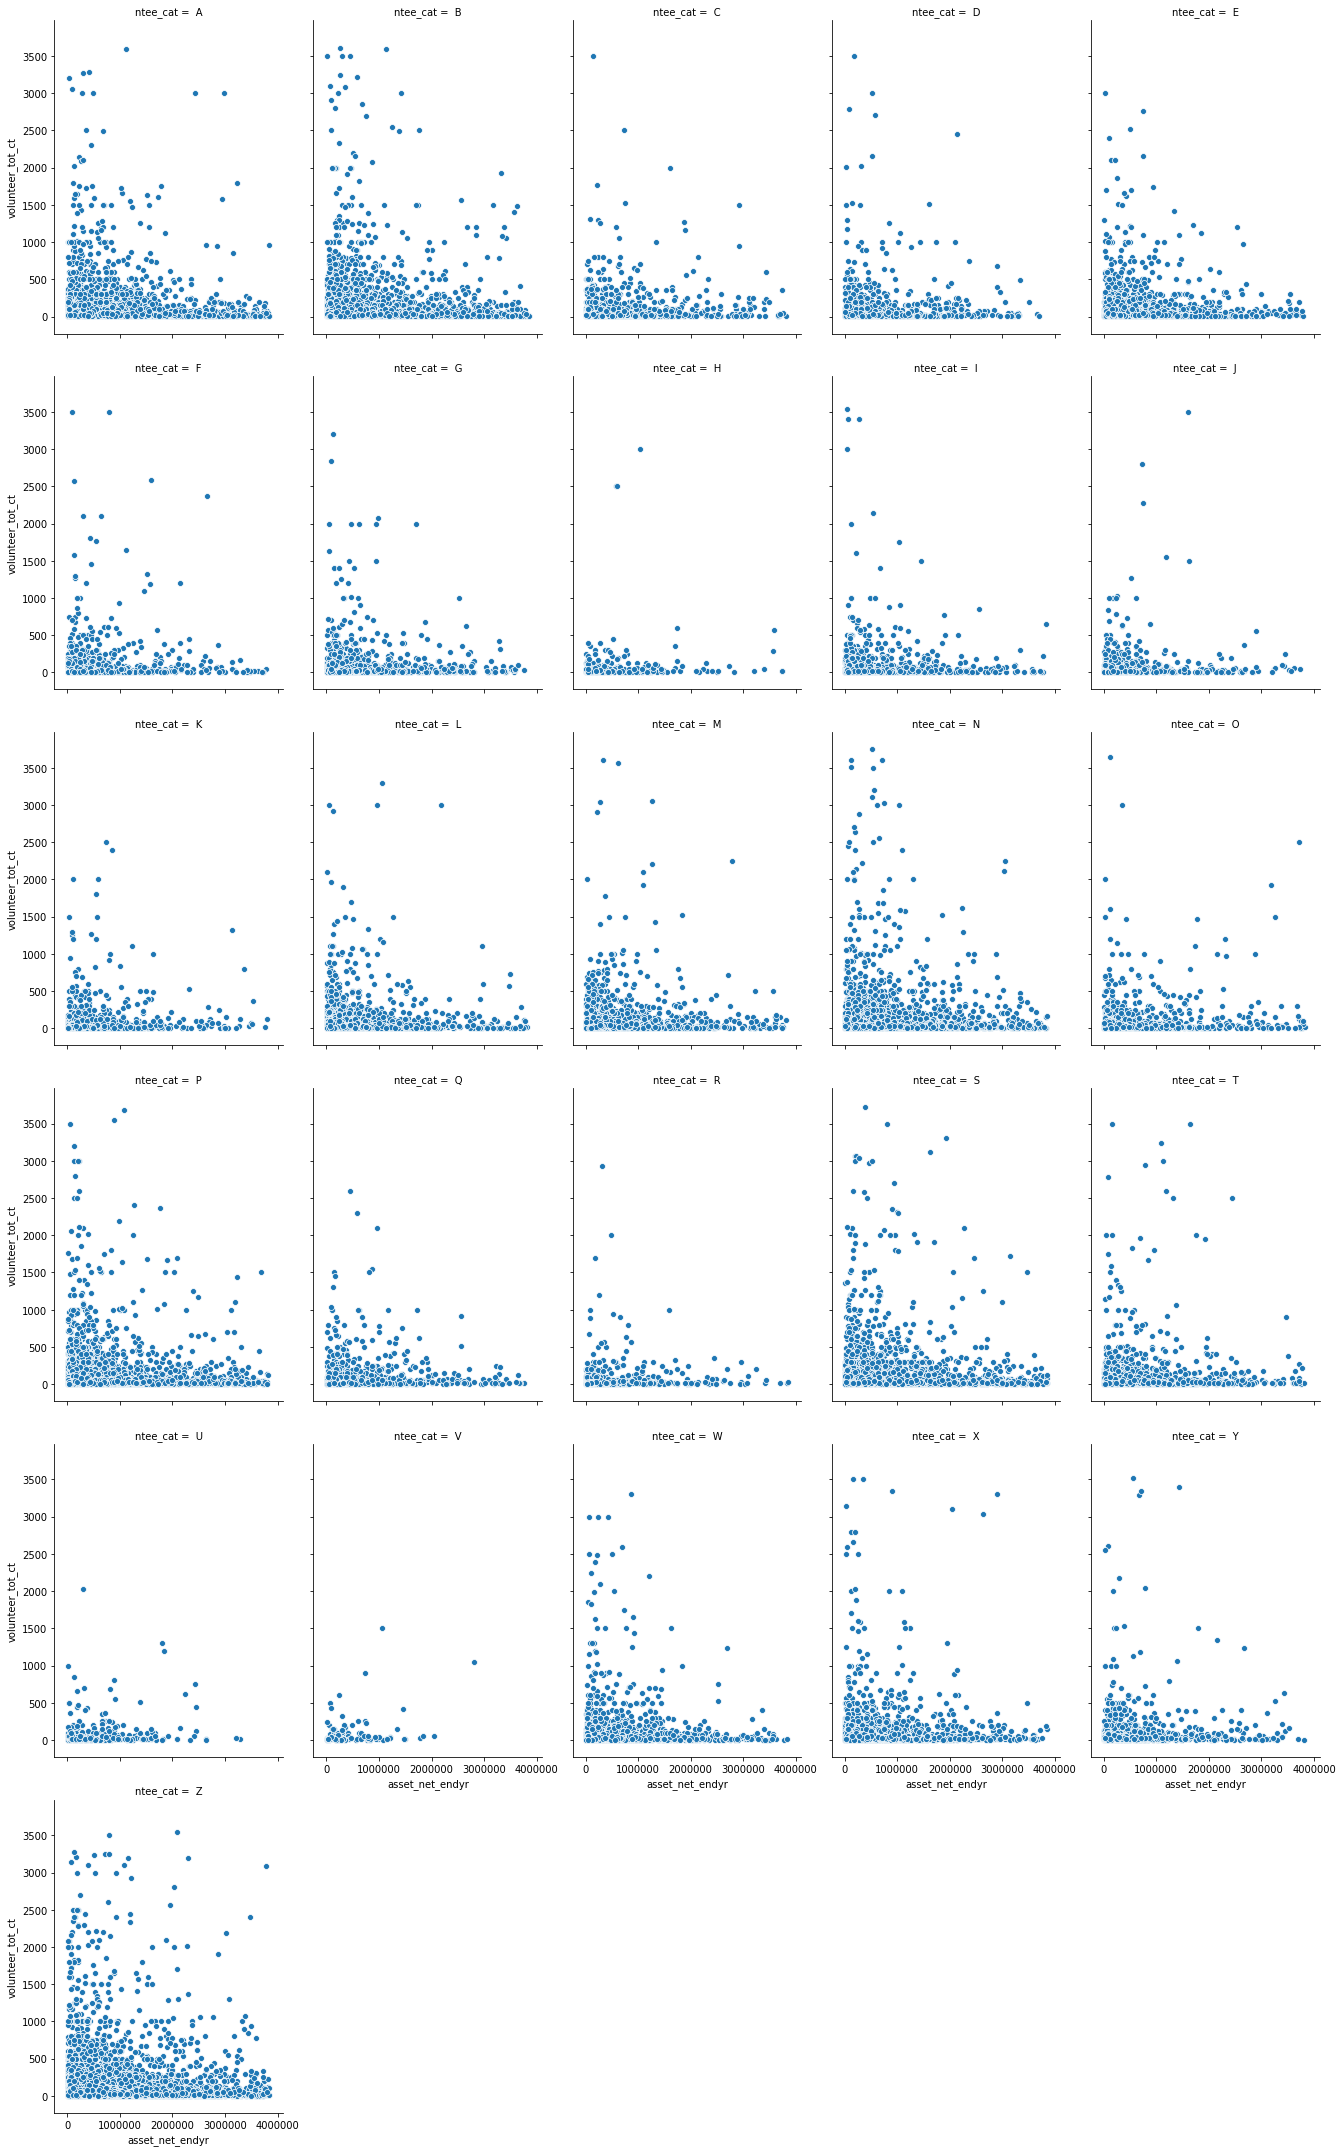

In [466]:
sns.relplot(x='asset_net_endyr', y='volunteer_tot_ct', col='ntee_cat',height=5, col_wrap=5, aspect=.75,
            data=df)

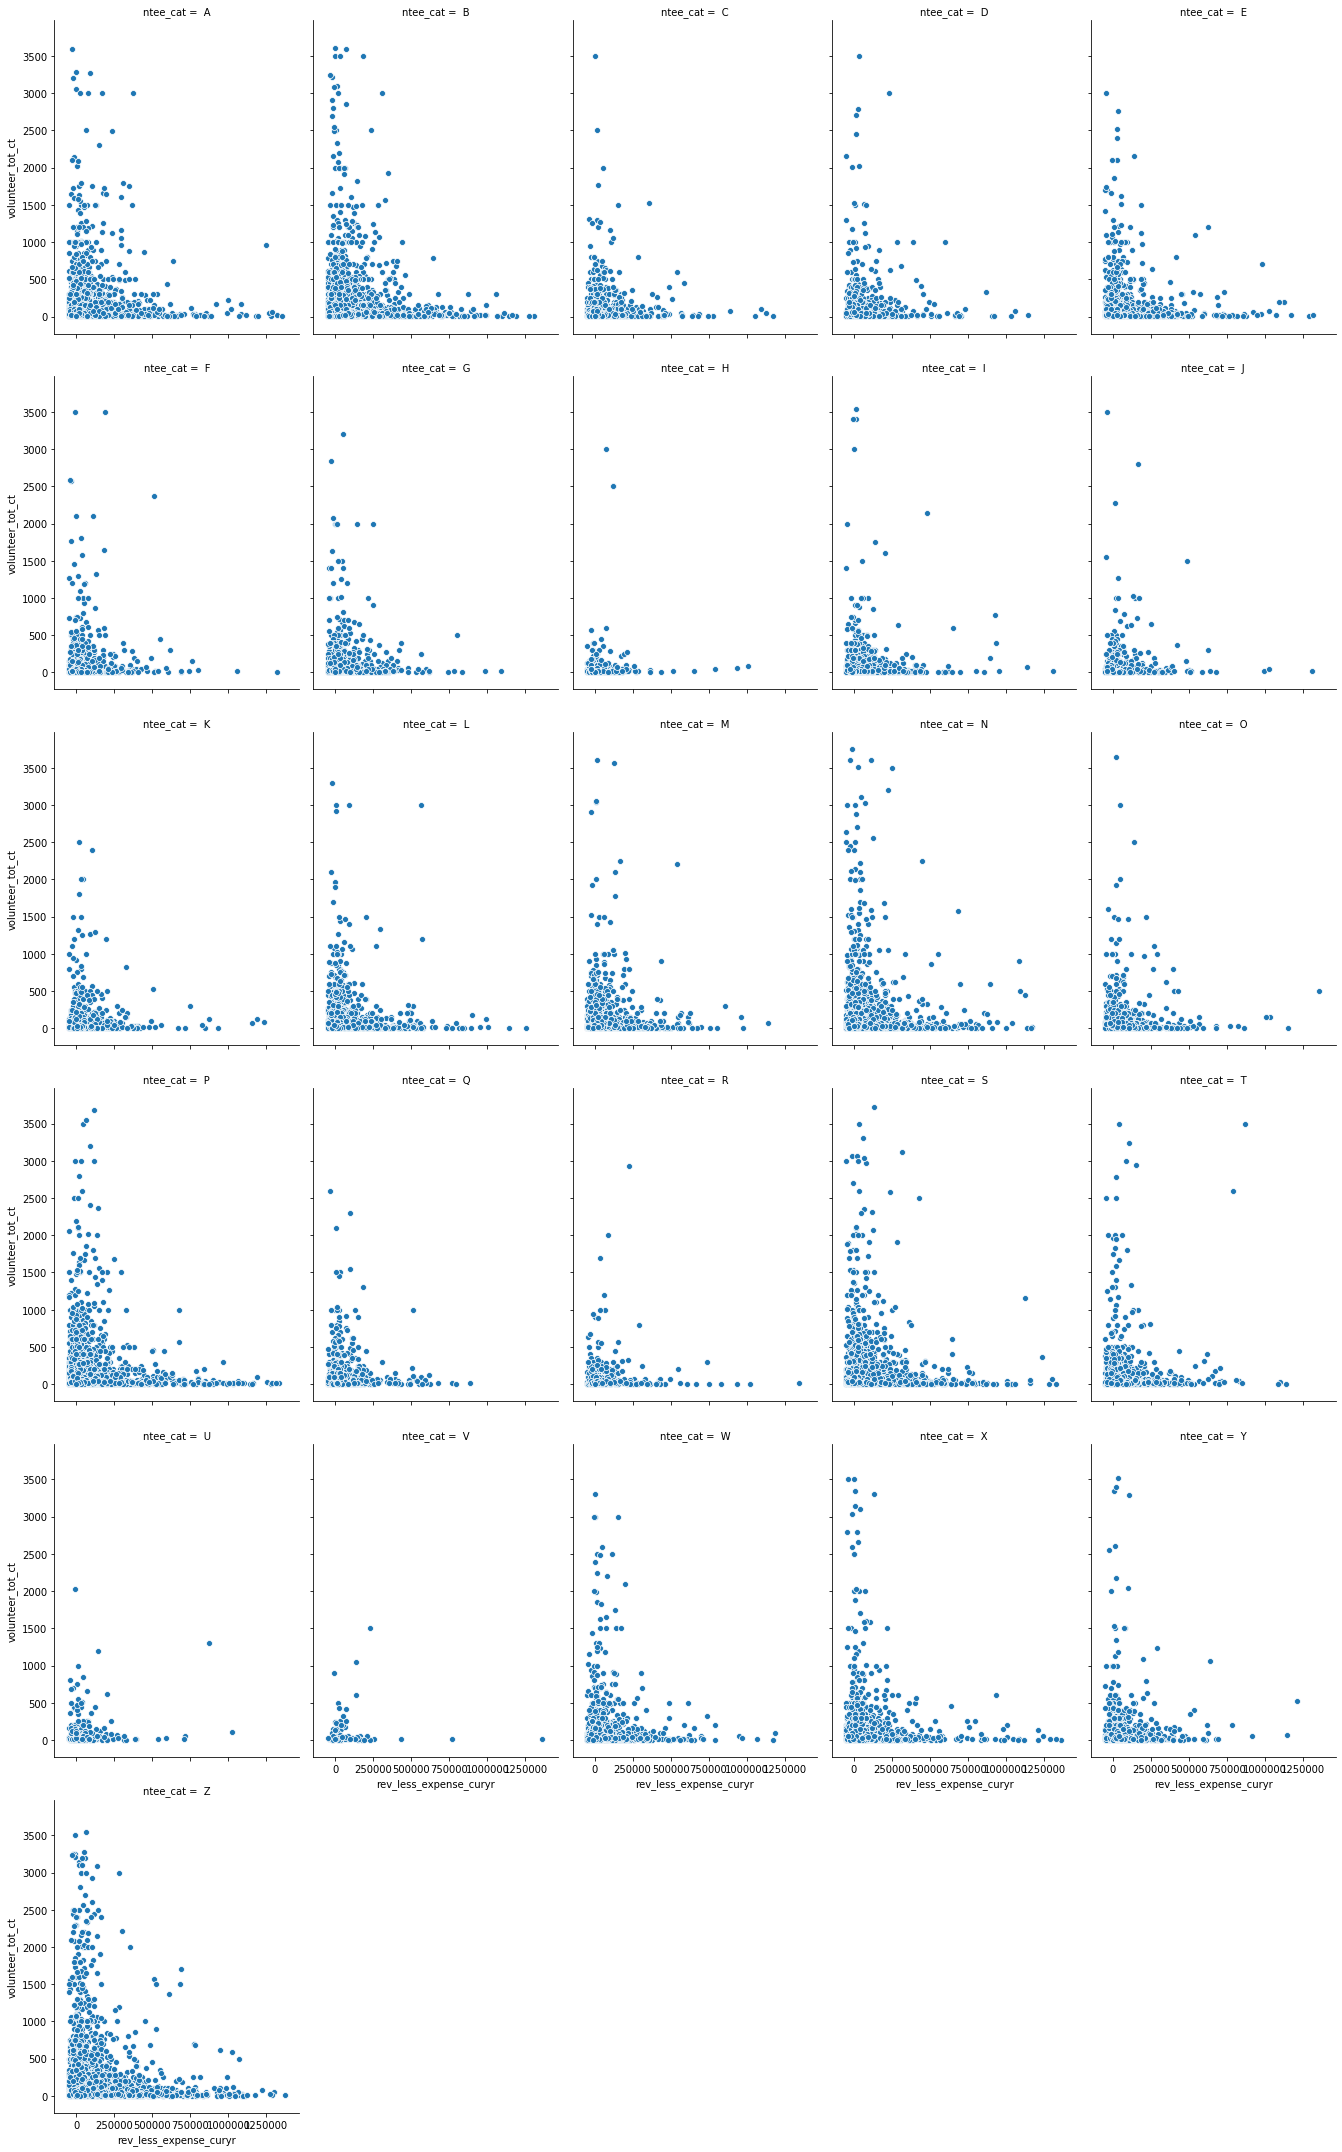

In [467]:
sns.relplot(x='rev_less_expense_curyr', y='volunteer_tot_ct', col='ntee_cat',height=5, col_wrap=5, aspect=.75,
            data=df)

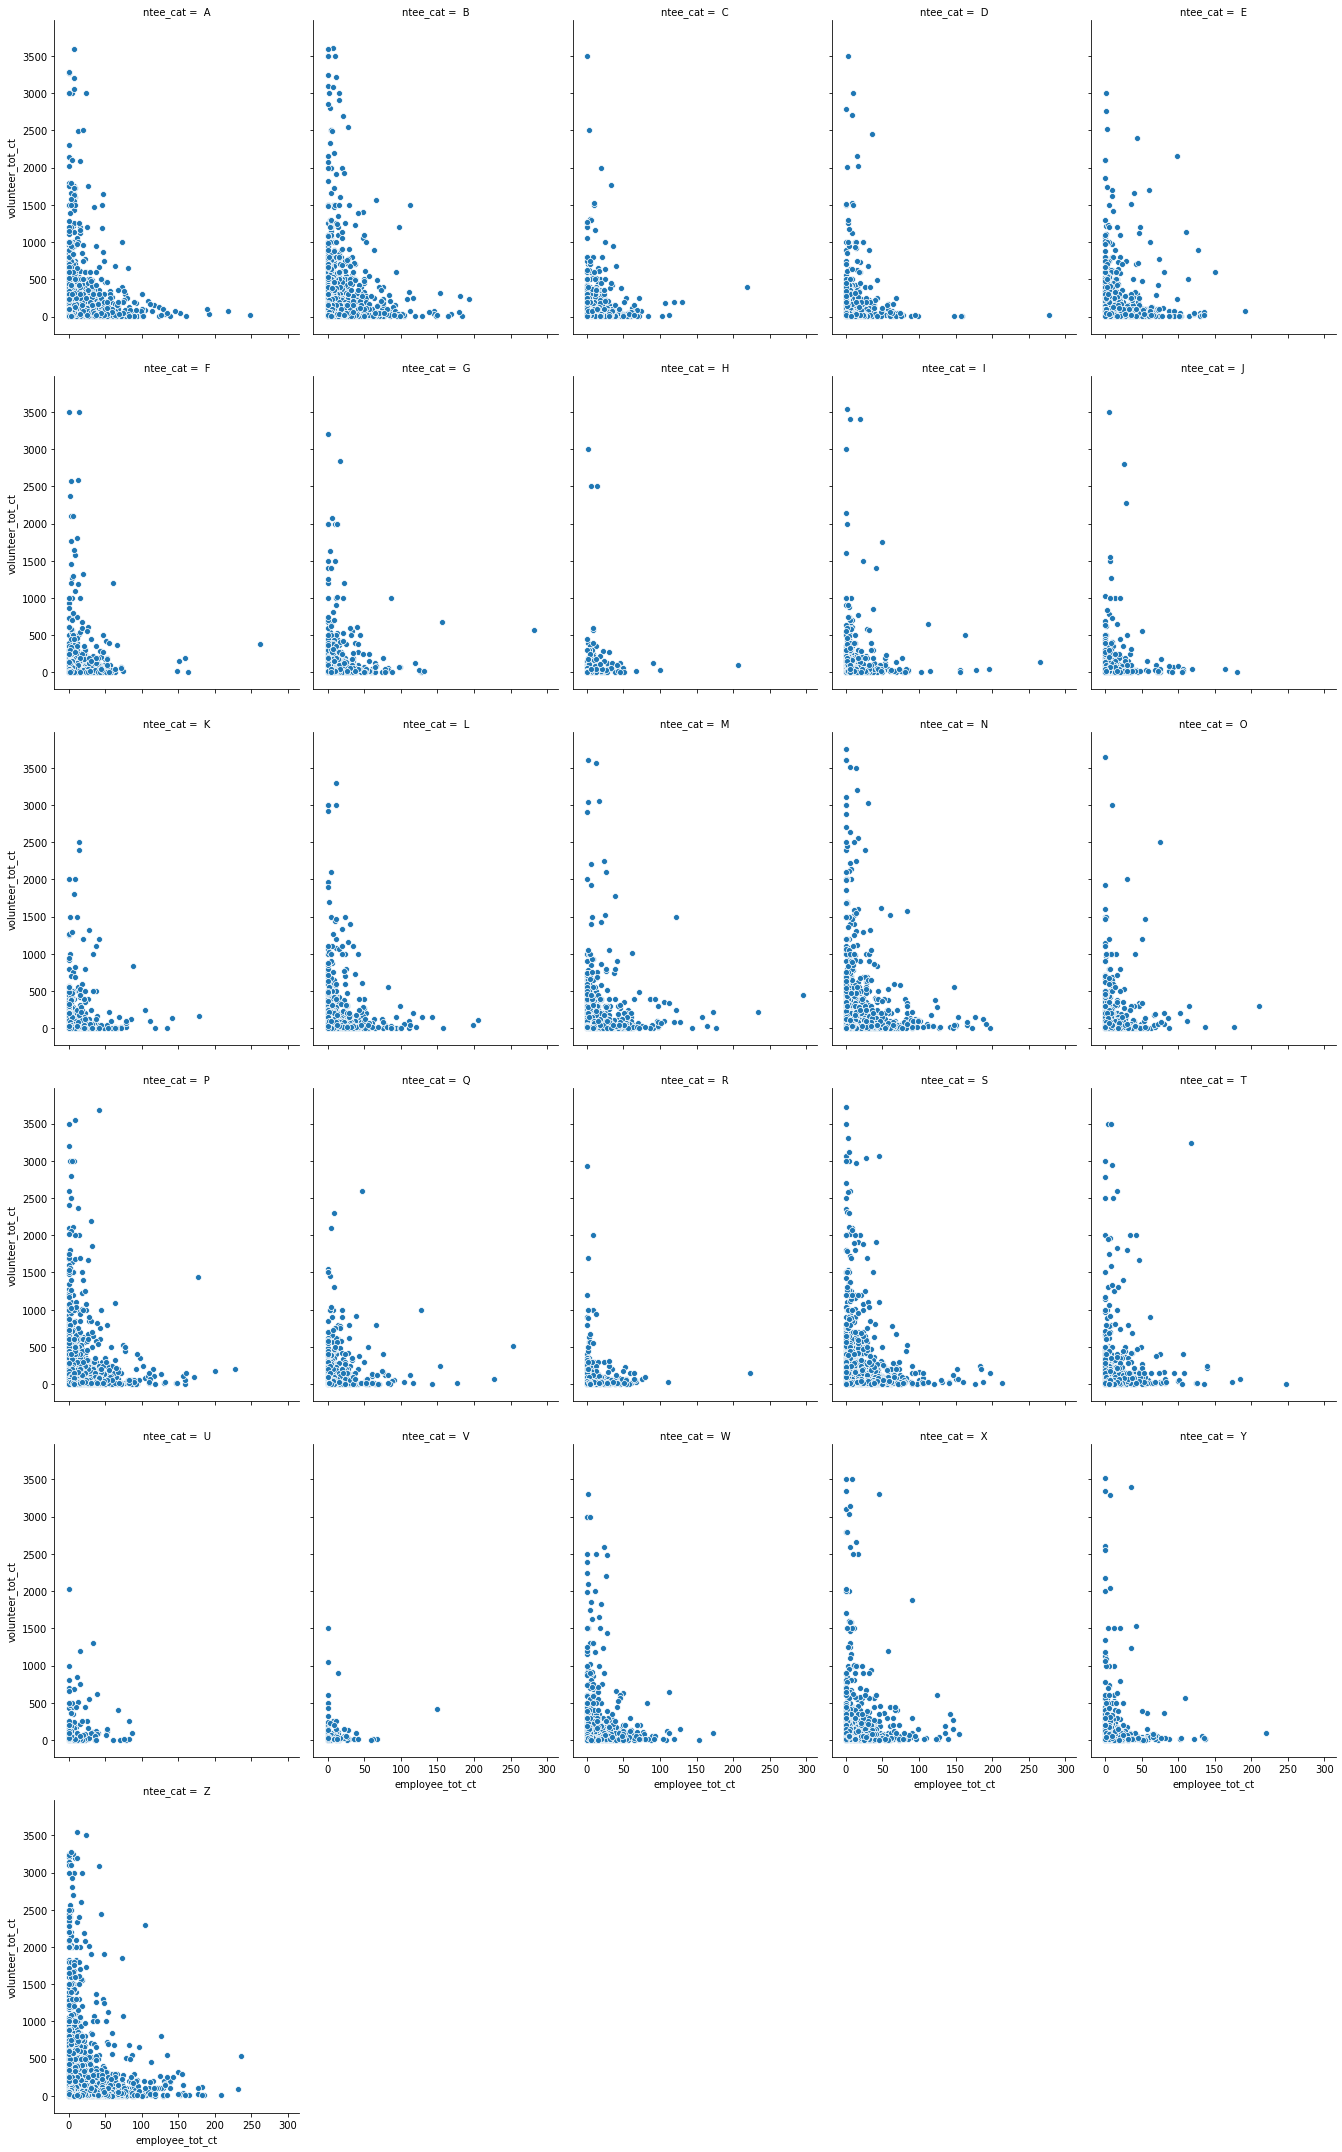

In [468]:
sns.relplot(x='employee_tot_ct', y='volunteer_tot_ct', col='ntee_cat',height=5, col_wrap=5, aspect=.75,
            data=df)

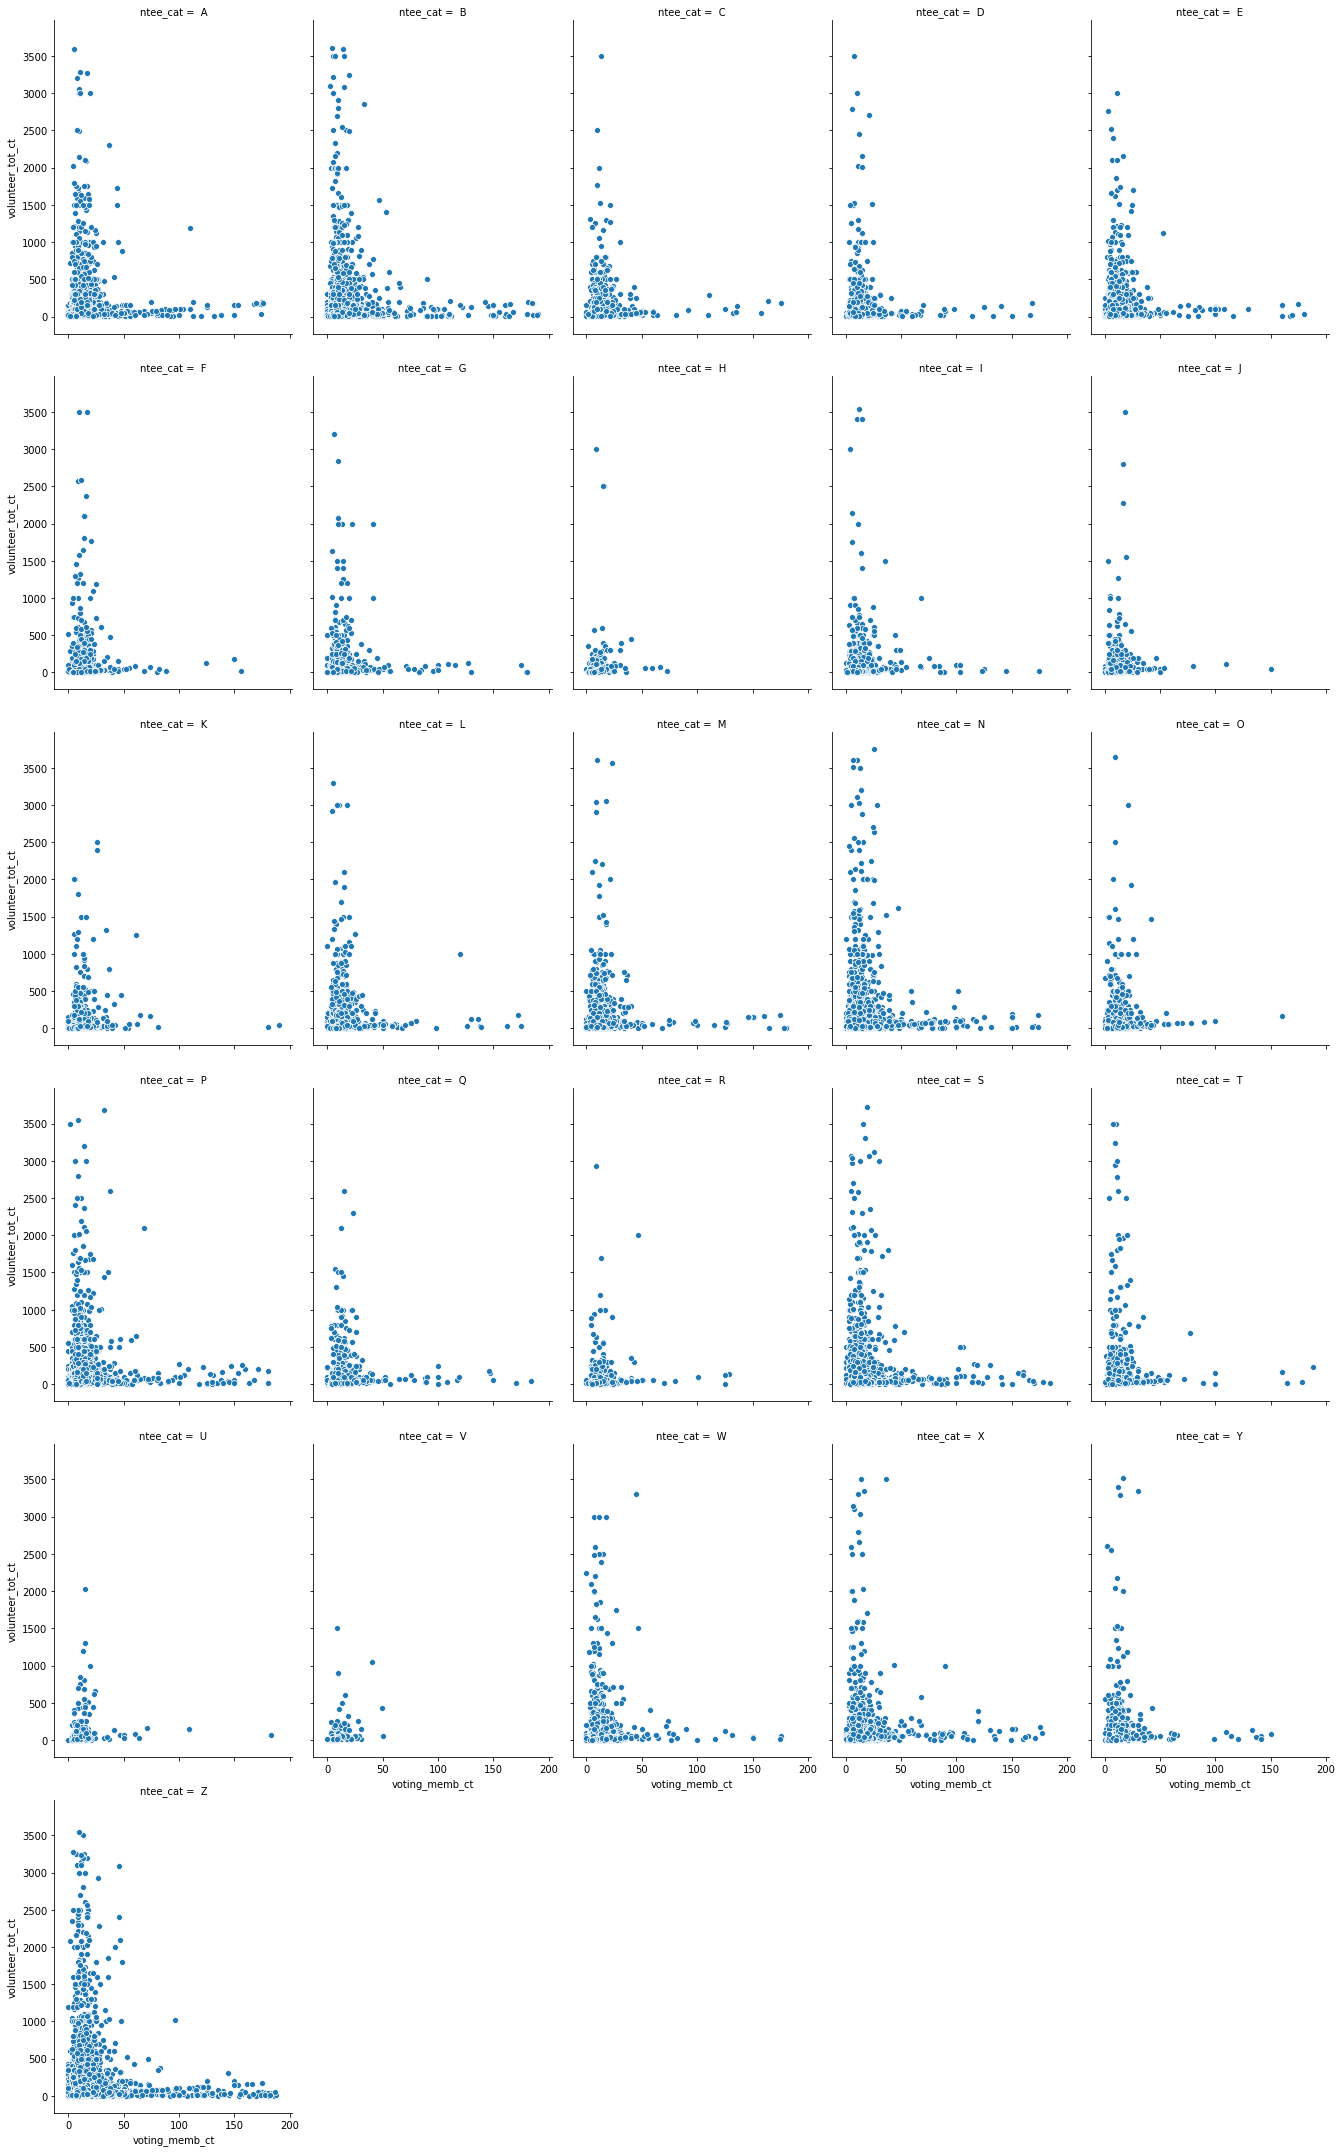

In [470]:
sns.relplot(x='voting_memb_ct', y='volunteer_tot_ct', col='ntee_cat',height=5, col_wrap=5, aspect=.75,
            data=df)

In [453]:
tips = sns.load_dataset("tips")
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
total_bill    244 non-null float64
tip           244 non-null float64
sex           244 non-null category
smoker        244 non-null category
day           244 non-null category
time          244 non-null category
size          244 non-null int64
dtypes: category(4), float64(2), int64(1)
memory usage: 7.3 KB


In [472]:
from sklearn.model_selection import StratifiedShuffleSplit

# Divide them into given bins to ensure that the number of ratings distribution represents the train and test sets
bins = [0, 10, 50, 100, 5000, np.inf]
labels=[1, 2, 3, 4, 5]
# create a new column containing the ratings bin the game is associated with
df['volunteer_tot_ct_cut'] = pd.cut(df['volunteer_tot_ct'], bins=bins, labels=labels)

# split data into training (80%) and testing (20%) sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ind, test_ind in split.split(df, df['volunteer_tot_ct_cut']):
    train_set, test_set = df.iloc[train_ind], df.iloc[test_ind]

test_label = test_set['volunteer_tot_ct'].copy()
test_identity = test_set[['name_org', 'ein']].copy()
test_set = test_set.drop(columns=['volunteer_tot_ct_cut','volunteer_tot_ct','name_org','tax_yr', 'ein', 'city', 'state','ntee_cat'])

train_label = train_set['volunteer_tot_ct'].copy()
train_identity = train_set[['name_org', 'ein']].copy()
train_set_binned = train_set['volunteer_tot_ct_cut'].copy() # label identifying the ratings bin the game occupies
train_set = train_set.drop(columns=['volunteer_tot_ct_cut','volunteer_tot_ct','name_org','tax_yr', 'ein', 'city', 'state', 'ntee_cat']) 
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19813 entries, 14834 to 62296
Data columns (total 40 columns):
org_form.association      19813 non-null int64
org_form.corp             19813 non-null int64
org_form.other_form       19813 non-null int64
org_form.trust            19813 non-null int64
formation_dur             19813 non-null float64
gross_receipts            19813 non-null float64
voting_memb_ct            19813 non-null float64
employee_tot_ct           19813 non-null float64
rev_tot_curyr             19813 non-null float64
expense_tot_curyr         19813 non-null float64
rev_less_expense_curyr    19813 non-null float64
asset_tot_endyr           19813 non-null float64
asset_net_endyr           19813 non-null float64
local_chapt               19813 non-null int64
code_A                    19813 non-null int64
code_B                    19813 non-null int64
code_C                    19813 non-null int64
code_D                    19813 non-null int64
code_E                 

In [473]:
train_set.to_sql('train_set', w, if_exists='replace', index=False)
train_label.to_sql('train_label', w, if_exists='replace', index=False)
test_set.to_sql('test_set', w, if_exists='replace', index=False)
test_label.to_sql('test_label', w, if_exists='replace', index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024898223688>,
      dtype=object)

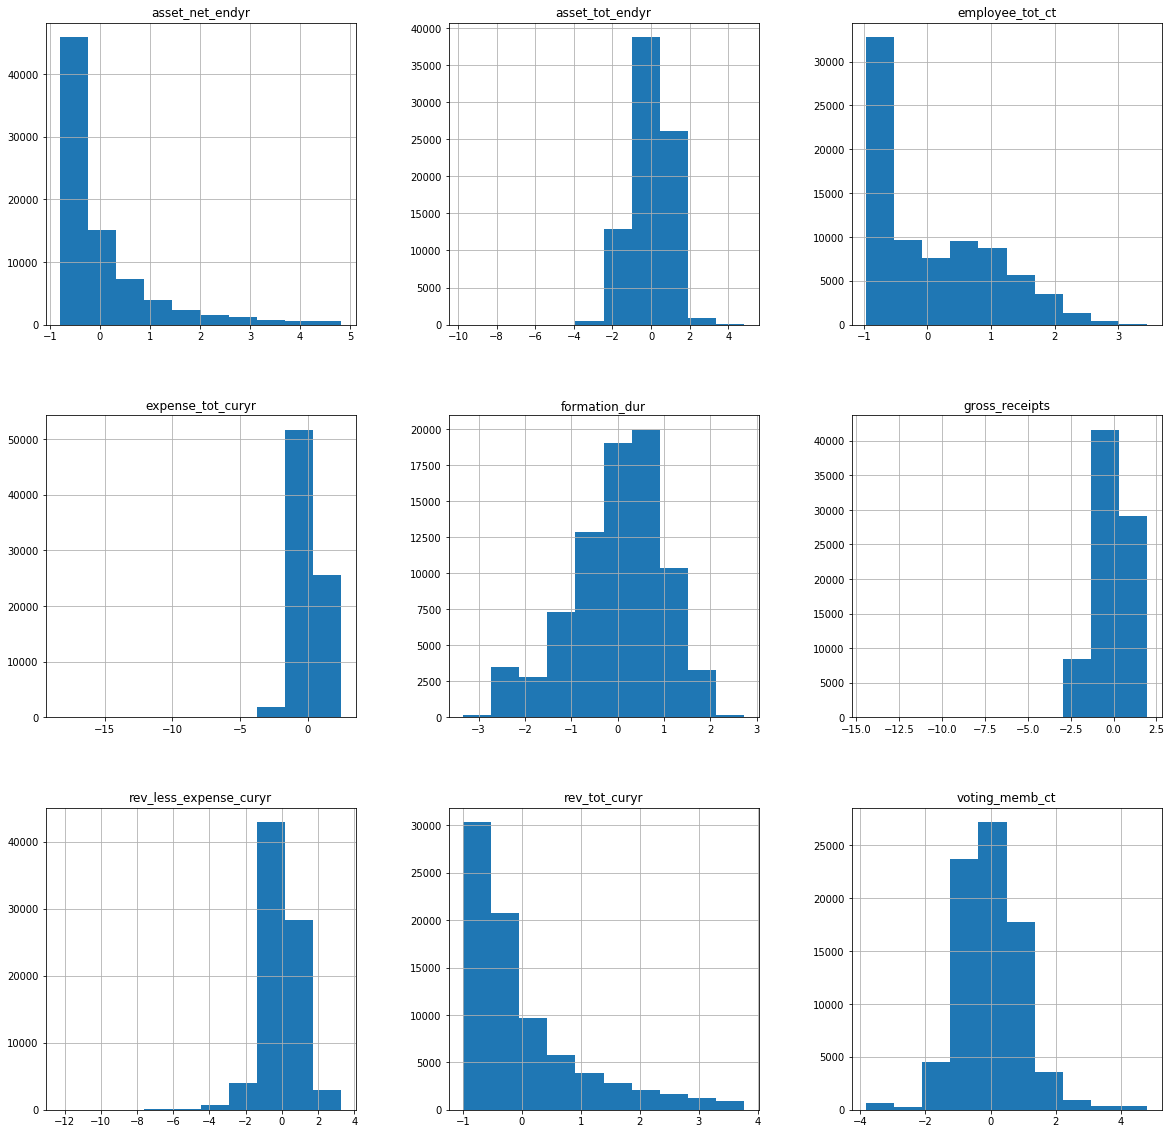

In [474]:
num_pipeline = Pipeline([
    ('trans_skew', SkewCorrector(skew_bound=0.2)),
    ('std_scaler', StandardScaler())
])
numeric_feat = train_set.dtypes[train_set.dtypes == 'float64'].index
cat_feat = train_set.dtypes[train_set.dtypes != 'float64'].index

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numeric_feat)
])
train_set_processed = train_set.copy()
# Correct negative values by adding constants
for feat_idx, feat in enumerate(numeric_feat):
    if (train_set_processed[feat]<0).any()==True:
        train_set_processed[feat]= train_set_processed[feat]+ abs(min(train_set_processed[feat]))

train_set_processed[numeric_feat] = full_pipeline.fit_transform(train_set_processed[numeric_feat])
train_set_processed[numeric_feat].hist(bins=10, figsize=(20,20))

In [475]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 107.57004794897364 ± 1.4697671676108608
